In [8]:
%pip install catboost
%pip install mlflow
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 65.0 MB/s eta 0:00:00:00:0100:01
Using cached packaging-23.2-py3-none-any.whl (53 kB)
Using cached urllib3-2.2.1-py3-none-any.whl (121 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-kernel 0.0.1 requires urllib3==1.25.11, but you have urllib3 2.2.1 which is incompatible.
botocore 1.23

In [15]:
import mlflow

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Train | Test split

In [3]:
df = pd.read_csv('dataset_v4_open.csv')
# df['embed_sum'] = df.loc[:, 'embed_0':'embed_49'].sum(axis=1)
# df.drop(columns=['embed_' + str(i) for i in range(50)], inplace=True)

train_df = df.iloc[:int(len(df) * 0.8)].reset_index(drop=True)
test_df = df.iloc[int(len(df) * 0.8):].reset_index(drop=True)
train_df.shape, test_df.shape

((968, 98), (243, 98))

In [4]:
X_train, X_test = train_df.drop(columns=['target', 'date']), test_df.drop(columns=['target', 'date'])
y_train, y_test = train_df['target'], test_df['target']

In [5]:
X_train.head()

,open,close,average,median,min,max,standard_deviation,price_range_average,exponential_smoothing,double_exponential_smoothing,average_window2,average_window3,average_window5,average_window7,median_window2,median_window3,median_window5,median_window7,min_window2,min_window3,min_window5,min_window7,max_window2,max_window3,max_window5,max_window7,standard_deviation_window2,standard_deviation_window3,standard_deviation_window5,standard_deviation_window7,price_range_average_window2,price_range_average_window3,price_range_average_window5,price_range_average_window7,exponential_smoothing_window2,exponential_smoothing_window3,exponential_smoothing_window5,exponential_smoothing_window7,double_exponential_smoothing_window2,double_exponential_smoothing_window3,...,embed_10,embed_11,embed_12,embed_13,embed_14,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24,embed_25,embed_26,embed_27,embed_28,embed_29,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39,embed_40,embed_41,embed_42,embed_43,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49
0,2571.70,2578.58,2580.589074,2581.880,2568.20,2591.32,5.707423,2.792593,2579.358027,2579.163860,2558.655093,2552.469753,2545.920556,2538.743492,2558.085,2551.370,2542.905,2538.240,2542.61,2535.02,2524.94,2498.73,2573.48,2573.48,2573.48,2573.48,7.245471,10.748313,12.262226,15.808983,2.413056,2.305185,2.403407,2.396693,2566.950416,2567.013219,2566.982171,2567.045733,2567.221763,2567.232961,...,-0.009145,-0.017099,0.053937,-0.021382,0.002379,-0.044615,0.030344,-0.031999,-0.026558,0.031940,0.006469,-0.097522,-0.025495,0.013765,0.017531,0.049443,-0.037943,0.018642,-0.015990,0.008725,0.025315,-0.047518,-0.022412,0.008870,0.057152,0.001072,0.066918,0.021410,0.016063,0.000087,0.001680,-0.008341,0.025299,-0.047279,0.011749,0.018427,-0.063661,0.020965,-0.020759,-0.022067
1,2578.37,2551.45,2567.153333,2567.385,2551.45,2585.16,8.121339,3.456481,2555.642652,2555.138077,2572.974352,2565.966420,2553.732556,2547.913016,2569.255,2565.520,2551.370,2542.905,2556.82,2542.61,2524.94,2514.99,2591.32,2591.32,2591.32,2591.32,8.853463,12.376898,18.177365,18.542792,2.717130,2.539568,2.404296,2.462540,2579.364861,2579.395097,2579.483669,2579.541000,2579.526934,2579.626288,...,0.064316,-0.068434,-0.016868,-0.050578,0.000476,-0.064271,0.011584,-0.032192,-0.014640,0.018673,-0.007736,-0.063405,-0.048910,-0.067918,0.054933,0.047476,0.004324,-0.025706,0.002638,-0.019209,0.012108,0.031421,0.026823,0.003390,-0.055900,0.022910,0.024787,0.043919,0.026515,-0.026181,-0.016479,0.033675,-0.005803,-0.016824,0.037643,0.017715,0.018166,-0.038453,-0.010503,-0.083353
2,2550.87,2559.72,2560.093704,2560.180,2550.71,2569.31,4.565859,3.074074,2555.420000,2555.586981,2573.871204,2571.034012,2561.030333,2553.906455,2575.015,2568.305,2562.730,2551.370,2551.45,2551.45,2535.02,2524.94,2591.32,2591.32,2591.32,2591.32,9.713729,9.021222,14.731261,17.144306,3.124537,2.963580,2.632926,2.609444,2555.715178,2555.728982,2555.677141,2555.695018,2555.514265,2555.647750,...,-0.029014,-0.081533,0.009149,-0.069129,0.045426,-0.047195,0.028309,-0.049277,-0.081661,-0.056326,0.027823,-0.027317,-0.017471,-0.018764,0.053599,0.023301,-0.025196,0.014830,-0.023544,0.016470,0.027150,-0.012344,0.003003,-0.016627,0.009584,-0.035848,-0.036979,0.019561,0.020065,-0.047644,0.002036,0.032801,0.011396,-0.036418,0.009460,-0.029904,-0.043184,0.045716,0.003264,-0.024021
3,2564.48,2545.12,2558.738333,2562.045,2542.74,2568.64,7.268994,2.575926,2545.710000,2545.344722,2563.623519,2569.278704,2565.029259,2556.558545,2562.515,2567.780,2564.110,2558.655,2550.71,2550.71,2542.61,2524.94,2585.16,2591.32,2591.32,2591.32,7.454664,10.583753,10.729023,16.478847,3.265278,3.107716,2.829852,2.650291,2555.342385,2555.118825,2555.069926,2555.123059,2555.135621,2555.031981,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [37]:
def build_charts():
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(3, 1, figsize=(18, 30))

    sns.lineplot(data=test_df, x='date', y=y_pred, ax=axs[0], label='Predict', color='red')
    sns.lineplot(data=test_df, x='date', y=y_test, ax=axs[0], label='Truth', color='blue')
    axs[0].set_title('Predict vs. Truth')
    axs[0].legend()
    
    sns.lineplot(data=test_df, x='date', y='exponential_smoothing_window7', ax=axs[1], label='Exp smoothing', color='red')
    sns.lineplot(data=test_df, x='date', y=y_test, ax=axs[1], label='Truth', color='blue')
    axs[1].set_title('Exponential Smoothing vs. Truth')
    axs[1].legend()

    sns.lineplot(data=test_df, x='date', y=y_pred, ax=axs[2], label='Predict', color='red')
    sns.lineplot(data=test_df, x='date', y='exponential_smoothing_window7', ax=axs[2], label='Exp smoothing', color='blue')
    axs[2].set_title('Predict vs. Exponential Smoothing')
    axs[2].legend()

    # plt.tight_layout()

    for ax in axs:
        ax.set_xticks(ax.get_xticks()[::len(test_df['date']) // 10])
        ax.set_xticklabels(test_df['date'][::len(test_df['date']) // 10], rotation=45)

    plt.show()

In [7]:
params = {
    'depth': 3,    
    'iterations': 1000,
    'learning_rate': 0.1,        
    'eval_metric': 'RMSE',
#    'leaf_estimation_iterations': 10,
    'random_seed': 42,
#    'task_type': 'GPU',
#    'devices': '0'
}

# CatBoost

In [8]:
# model = CatBoostRegressor(task_type='GPU', devices='0')
model = CatBoostRegressor()

In [9]:
model.fit(X_train, y_train)

Learning rate set to 0.040733
0:	learn: 581.1980787	total: 54.1ms	remaining: 54s
1:	learn: 560.5007286	total: 56.1ms	remaining: 28s
2:	learn: 540.0424899	total: 58.3ms	remaining: 19.4s
3:	learn: 520.6006377	total: 60ms	remaining: 15s
4:	learn: 502.0942232	total: 61.8ms	remaining: 12.3s
5:	learn: 484.1385379	total: 63.6ms	remaining: 10.5s
6:	learn: 467.7875563	total: 65.4ms	remaining: 9.28s
7:	learn: 450.6010755	total: 67.3ms	remaining: 8.34s
8:	learn: 434.6710859	total: 69.2ms	remaining: 7.62s
9:	learn: 419.0439637	total: 71ms	remaining: 7.03s
10:	learn: 404.6090436	total: 72.8ms	remaining: 6.55s
11:	learn: 390.2017236	total: 74.7ms	remaining: 6.15s
12:	learn: 376.1203883	total: 76.5ms	remaining: 5.81s
13:	learn: 362.6386458	total: 78.3ms	remaining: 5.52s
14:	learn: 350.1489804	total: 80.2ms	remaining: 5.26s
15:	learn: 337.6469290	total: 82.1ms	remaining: 5.05s
16:	learn: 325.5575028	total: 83.9ms	remaining: 4.85s
17:	learn: 313.7631086	total: 85.8ms	remaining: 4.68s
18:	learn: 302.453

In [10]:
y_pred = model.predict(X_test)

In [11]:
print(mape(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

0.8883893628551564
27.144135937881845


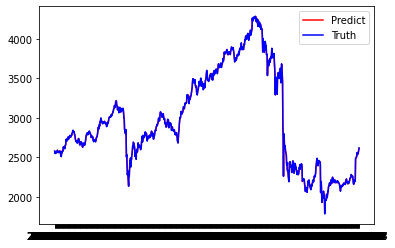

In [13]:
plt.plot(train_df['date'], model.predict(X_train), label='Predict', color='red')
plt.plot(train_df['date'], y_train, label='Truth', color='blue')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

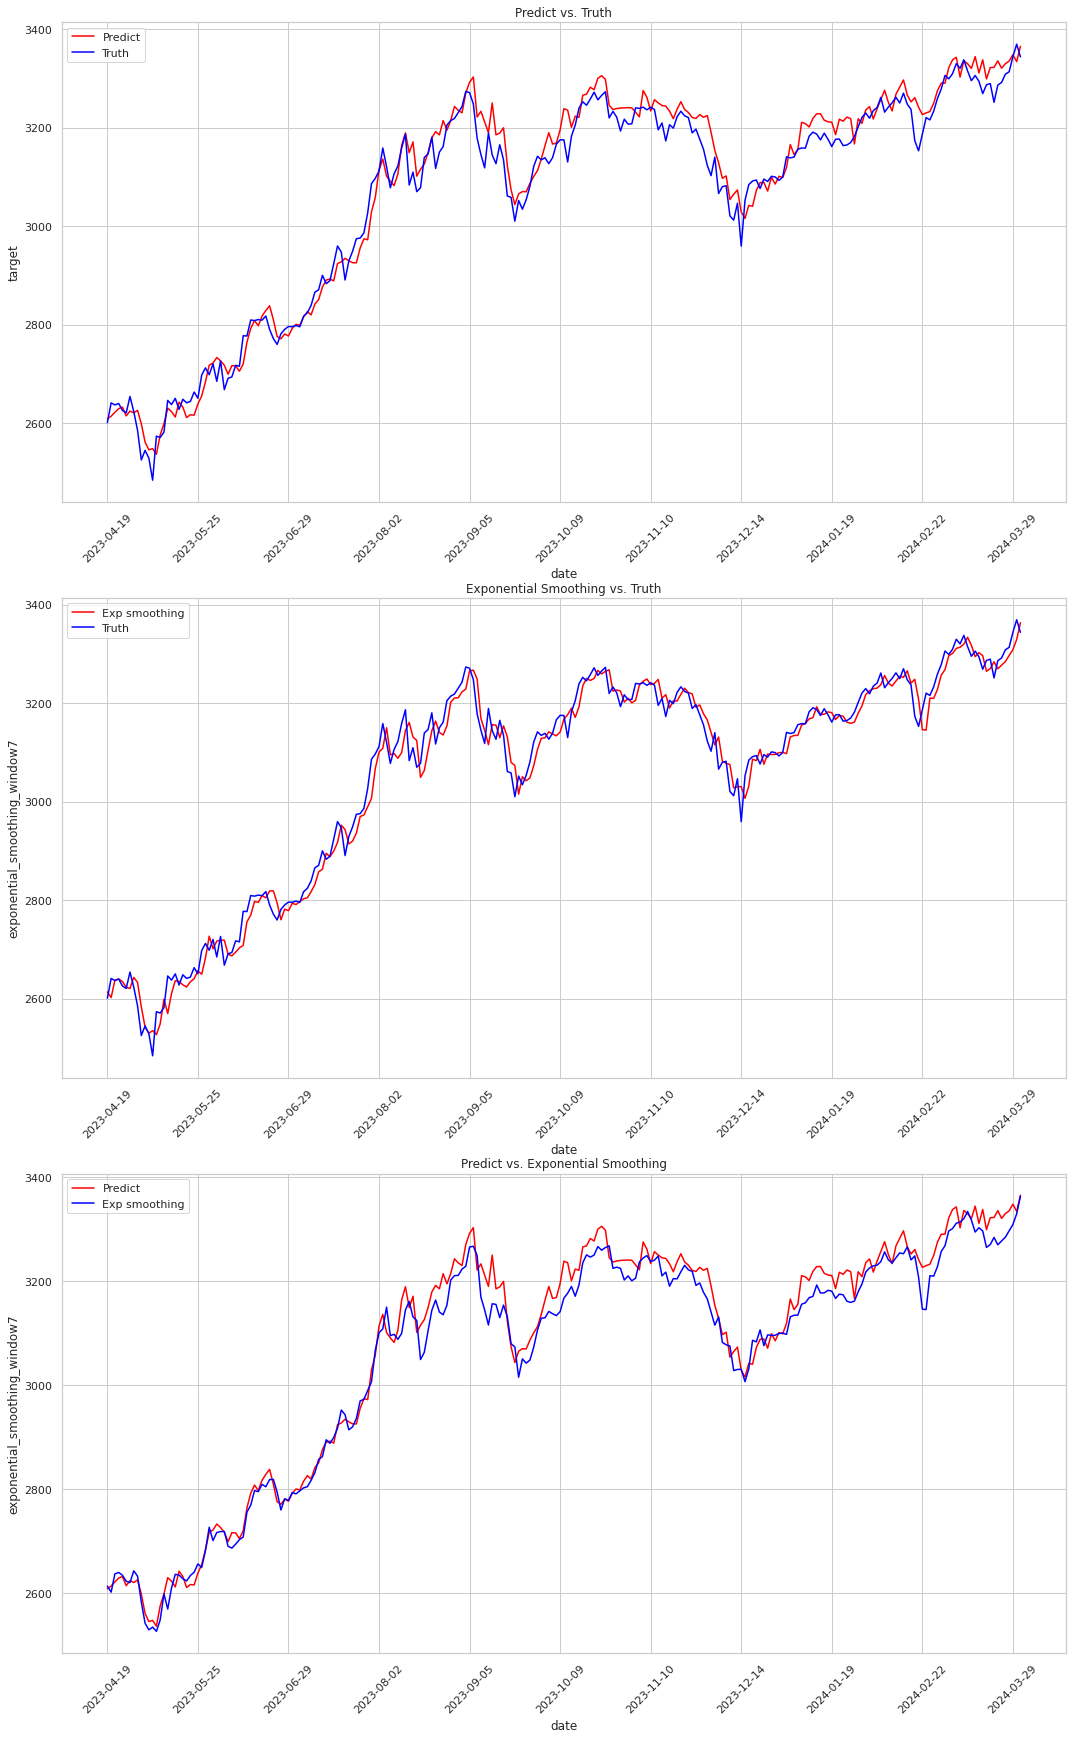

In [38]:
build_charts()

MAPE: 1.839425580170178


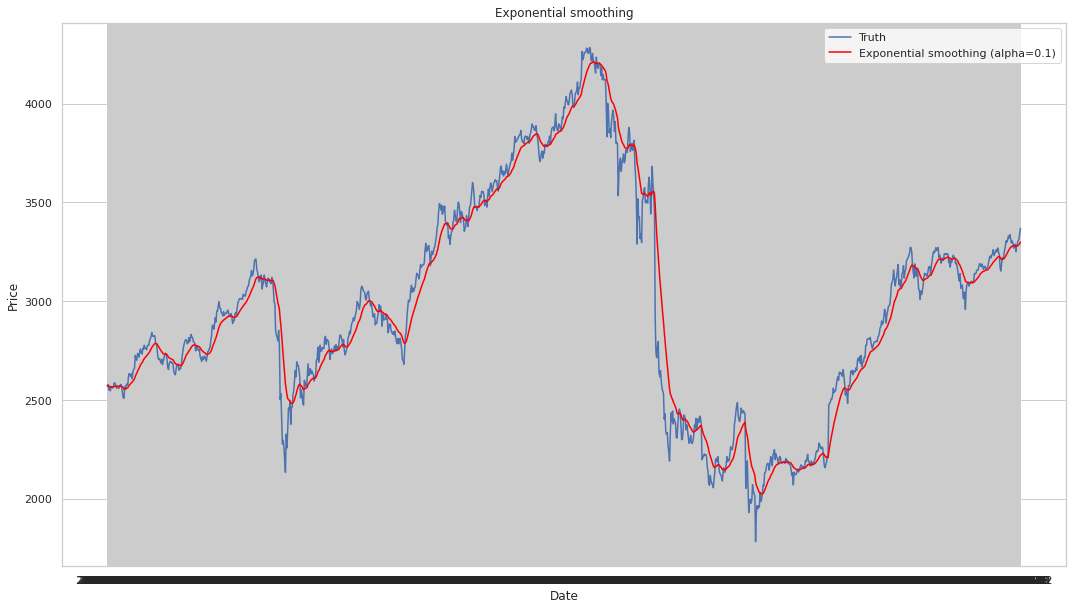

In [43]:
data = df.copy()
alpha = 0.1
data.set_index('date', inplace=True)
data['exponential_smoothing'] = data['open'].ewm(alpha=alpha, adjust=False).mean()

print("MAPE:", mape(y_test, data['exponential_smoothing'][int(len(df) * 0.8):]))

plt.figure(figsize=(18, 10))
plt.plot(data.index, data['open'], label='Truth')
plt.plot(data.index, data['exponential_smoothing'], label=f'Exponential smoothing (alpha={alpha})', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Exponential smoothing')
plt.legend()
plt.show() 

In [65]:
feature_importances = model.get_feature_importance(type='FeatureImportance')
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, feature_importances))
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
for feature, importance in sorted_importance_dict.items():
    print(f"{feature}: {importance}")

exponential_smoothing_window3: 8.619274807517854
exponential_smoothing_window5: 7.77382582796196
min_window2: 7.232327604825666
double_exponential_smoothing: 6.8061625526796545
average: 4.837613404175299
exponential_smoothing: 4.707826267266608
max: 4.0546490203262575
open: 3.7135682749979497
average_window2: 3.704521989025084
average_window3: 3.604786981850603
min_window7: 3.4580011369382633
close: 3.4418725302022564
min_window5: 3.207836488772389
median_window3: 3.0460832243448115
median: 2.8418508034411603
double_exponential_smoothing_window2: 2.736345166308776
exponential_smoothing_window2: 2.5438951190152426
median_window2: 2.402334465988188
min_window3: 2.20324327159537
min: 1.7271735225289488
exponential_smoothing_window7: 1.6894781192650126
double_exponential_smoothing_window7: 1.5913132643306938
max_window7: 1.4109156023831149
double_exponential_smoothing_window3: 1.35786690552517
median_window5: 0.9763451213286694
median_window7: 0.8399853986210034
average_window7: 0.74069404

In [66]:
# save 
model.save_model('catboost_best')

# Catboost Optuna

## Train | Valid | Test split

In [57]:
train_df = df.iloc[:int(len(df) * 0.7)].reset_index(drop=True)
valid_df = df.iloc[int(len(df) * 0.7):int(len(df) * 0.85)].reset_index(drop=True)
test_df = df.iloc[int(len(df) * 0.85):].reset_index(drop=True)
train_df.shape, valid_df.shape, test_df.shape

((847, 94), (182, 94), (182, 94))

In [58]:
X_train, y_train = train_df.drop(columns=['date', 'target']), train_df['target']
X_valid, y_valid = valid_df.drop(columns=['date', 'target']), valid_df['target']
X_test, y_test = test_df.drop(columns=['date', 'target']), test_df['target']

In [39]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 20, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 100.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'task_type': 'GPU',
        'devices': '0'
    }
    model = CatBoostRegressor(**params, verbose=False)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    
    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    
    return rmse

In [40]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, show_progress_bar=True)

[I 2024-04-10 11:28:26,157] A new study created in memory with name: no-name-e9877762-7299-46ba-9104-82ad80680be3
Best trial: 0. Best value: 59.9092:   0%|          | 1/200 [00:00<02:29,  1.33it/s]

[I 2024-04-10 11:28:26,906] Trial 0 finished with value: 59.90924525865818 and parameters: {'iterations': 414, 'depth': 5, 'learning_rate': 0.264349201416566, 'l2_leaf_reg': 0.11726172321271901, 'bagging_temperature': 1.1383257949932377, 'random_strength': 0.07041283635595784, 'border_count': 184}. Best is trial 0 with value: 59.90924525865818.


Best trial: 1. Best value: 59.6669:   1%|          | 2/200 [00:02<03:47,  1.15s/it]

[I 2024-04-10 11:28:28,331] Trial 1 finished with value: 59.6668964861128 and parameters: {'iterations': 496, 'depth': 4, 'learning_rate': 0.10024884486178672, 'l2_leaf_reg': 1.414474041027532, 'bagging_temperature': 0.5494353727694272, 'random_strength': 1.1678678632001658, 'border_count': 113}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   2%|▏         | 3/200 [00:19<27:56,  8.51s/it]

[I 2024-04-10 11:28:45,599] Trial 2 finished with value: 69.48030686816489 and parameters: {'iterations': 723, 'depth': 8, 'learning_rate': 0.006049676118513133, 'l2_leaf_reg': 0.5452057428787918, 'bagging_temperature': 0.790829832822421, 'random_strength': 0.891148417575477, 'border_count': 214}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   2%|▏         | 4/200 [00:21<19:40,  6.03s/it]

[I 2024-04-10 11:28:47,816] Trial 3 finished with value: 82.94103832971432 and parameters: {'iterations': 685, 'depth': 6, 'learning_rate': 0.10305593731017831, 'l2_leaf_reg': 1.363944605400534, 'bagging_temperature': 0.020401220022658838, 'random_strength': 9.296073534690375, 'border_count': 51}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   2%|▎         | 5/200 [00:26<18:23,  5.66s/it]

[I 2024-04-10 11:28:52,829] Trial 4 finished with value: 73.81543549868022 and parameters: {'iterations': 639, 'depth': 4, 'learning_rate': 0.13178815514272538, 'l2_leaf_reg': 0.11246900066925551, 'bagging_temperature': 6.795514075089263, 'random_strength': 0.12831289856246372, 'border_count': 251}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   3%|▎         | 6/200 [00:41<28:50,  8.92s/it]

[I 2024-04-10 11:29:08,078] Trial 5 finished with value: 61.8707876043774 and parameters: {'iterations': 781, 'depth': 8, 'learning_rate': 0.010348181125083874, 'l2_leaf_reg': 15.209042017068407, 'bagging_temperature': 0.4207918624866728, 'random_strength': 0.02061651930077394, 'border_count': 107}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   4%|▎         | 7/200 [00:52<30:07,  9.37s/it]

[I 2024-04-10 11:29:18,368] Trial 6 finished with value: 139.0516952965683 and parameters: {'iterations': 898, 'depth': 10, 'learning_rate': 0.1769203498971343, 'l2_leaf_reg': 0.6594270117601365, 'bagging_temperature': 39.83046921134028, 'random_strength': 0.525441483596663, 'border_count': 243}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   4%|▍         | 8/200 [00:53<22:07,  6.92s/it]

[I 2024-04-10 11:29:20,035] Trial 7 finished with value: 68.31706311911724 and parameters: {'iterations': 222, 'depth': 7, 'learning_rate': 0.03413180074454793, 'l2_leaf_reg': 0.14453316636234917, 'bagging_temperature': 0.014253112511522968, 'random_strength': 0.0026413913974023774, 'border_count': 58}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   4%|▍         | 9/200 [01:07<28:29,  8.95s/it]

[I 2024-04-10 11:29:33,456] Trial 8 finished with value: 68.67266539454413 and parameters: {'iterations': 685, 'depth': 8, 'learning_rate': 0.015077746890903613, 'l2_leaf_reg': 3.6878978699422382, 'bagging_temperature': 1.5969886316209818, 'random_strength': 1.7809691807782528, 'border_count': 105}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   5%|▌         | 10/200 [01:17<29:50,  9.43s/it]

[I 2024-04-10 11:29:43,948] Trial 9 finished with value: 69.94783281969141 and parameters: {'iterations': 576, 'depth': 8, 'learning_rate': 0.008705156050627428, 'l2_leaf_reg': 8.925956550624266, 'bagging_temperature': 0.5653597465407789, 'random_strength': 0.007689775457278059, 'border_count': 73}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   6%|▌         | 11/200 [01:19<22:21,  7.10s/it]

[I 2024-04-10 11:29:45,759] Trial 10 finished with value: 62.27073902032287 and parameters: {'iterations': 468, 'depth': 4, 'learning_rate': 0.053899205369083145, 'l2_leaf_reg': 0.0030089317685675922, 'bagging_temperature': 0.09584833824416124, 'random_strength': 9.910492050009012, 'border_count': 160}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   6%|▌         | 12/200 [01:21<16:57,  5.41s/it]

[I 2024-04-10 11:29:47,317] Trial 11 finished with value: 86.70188250915976 and parameters: {'iterations': 371, 'depth': 5, 'learning_rate': 0.2980689976952109, 'l2_leaf_reg': 0.03535282261452953, 'bagging_temperature': 6.020864751159631, 'random_strength': 0.055631484291909165, 'border_count': 167}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   6%|▋         | 13/200 [01:22<12:57,  4.16s/it]

[I 2024-04-10 11:29:48,595] Trial 12 finished with value: 61.097130774542194 and parameters: {'iterations': 418, 'depth': 5, 'learning_rate': 0.2873176908303731, 'l2_leaf_reg': 0.010849344480733675, 'bagging_temperature': 0.13231902929703956, 'random_strength': 0.15967231056443684, 'border_count': 192}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   7%|▋         | 14/200 [01:24<10:33,  3.41s/it]

[I 2024-04-10 11:29:50,270] Trial 13 finished with value: 70.84039787151008 and parameters: {'iterations': 307, 'depth': 5, 'learning_rate': 0.0666886769823729, 'l2_leaf_reg': 0.19672076092515972, 'bagging_temperature': 3.916777148512576, 'random_strength': 0.26873708194670326, 'border_count': 126}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   8%|▊         | 15/200 [01:28<10:58,  3.56s/it]

[I 2024-04-10 11:29:54,181] Trial 14 finished with value: 110.83074456061668 and parameters: {'iterations': 522, 'depth': 4, 'learning_rate': 0.025320568390239915, 'l2_leaf_reg': 0.021433892373502, 'bagging_temperature': 39.520004424137696, 'random_strength': 2.368149286470243, 'border_count': 134}. Best is trial 1 with value: 59.6668964861128.


Best trial: 1. Best value: 59.6669:   8%|▊         | 16/200 [01:29<09:23,  3.06s/it]

[I 2024-04-10 11:29:56,081] Trial 15 finished with value: 60.48380885287503 and parameters: {'iterations': 320, 'depth': 6, 'learning_rate': 0.09489704291497456, 'l2_leaf_reg': 2.307261437764947, 'bagging_temperature': 0.12070437648138871, 'random_strength': 0.034850800827069234, 'border_count': 192}. Best is trial 1 with value: 59.6668964861128.


Best trial: 16. Best value: 59.2675:   8%|▊         | 17/200 [01:33<09:26,  3.10s/it]

[I 2024-04-10 11:29:59,264] Trial 16 finished with value: 59.267461560684445 and parameters: {'iterations': 531, 'depth': 6, 'learning_rate': 0.16773676122939526, 'l2_leaf_reg': 0.0017833664422025107, 'bagging_temperature': 2.228614032594606, 'random_strength': 0.011210204932681657, 'border_count': 91}. Best is trial 16 with value: 59.267461560684445.


Best trial: 16. Best value: 59.2675:   9%|▉         | 18/200 [01:38<11:28,  3.78s/it]

[I 2024-04-10 11:30:04,642] Trial 17 finished with value: 116.39922104829073 and parameters: {'iterations': 545, 'depth': 6, 'learning_rate': 0.061476421556958205, 'l2_leaf_reg': 0.0010706615592160791, 'bagging_temperature': 14.202362954359828, 'random_strength': 0.0015065603220058093, 'border_count': 86}. Best is trial 16 with value: 59.267461560684445.


Best trial: 18. Best value: 55.7128:  10%|▉         | 19/200 [01:45<14:11,  4.70s/it]

[I 2024-04-10 11:30:11,486] Trial 18 finished with value: 55.712785414288795 and parameters: {'iterations': 931, 'depth': 10, 'learning_rate': 0.1701648102367635, 'l2_leaf_reg': 0.00559427592857678, 'bagging_temperature': 0.281739987873227, 'random_strength': 0.007580152080790388, 'border_count': 100}. Best is trial 18 with value: 55.712785414288795.


Best trial: 18. Best value: 55.7128:  10%|█         | 20/200 [01:48<12:26,  4.15s/it]

[I 2024-04-10 11:30:14,343] Trial 19 finished with value: 62.863065791427935 and parameters: {'iterations': 949, 'depth': 10, 'learning_rate': 0.17192316192398863, 'l2_leaf_reg': 0.00394389816559496, 'bagging_temperature': 0.04447411212607186, 'random_strength': 0.009078057028198758, 'border_count': 40}. Best is trial 18 with value: 55.712785414288795.


Best trial: 18. Best value: 55.7128:  10%|█         | 21/200 [01:55<14:46,  4.95s/it]

[I 2024-04-10 11:30:21,175] Trial 20 finished with value: 61.02709130873222 and parameters: {'iterations': 835, 'depth': 9, 'learning_rate': 0.16559709869407022, 'l2_leaf_reg': 0.0010634901631281792, 'bagging_temperature': 2.146189584129014, 'random_strength': 0.0057647303028135095, 'border_count': 84}. Best is trial 18 with value: 55.712785414288795.


Best trial: 18. Best value: 55.7128:  11%|█         | 22/200 [01:56<11:35,  3.91s/it]

[I 2024-04-10 11:30:22,649] Trial 21 finished with value: 61.97673246436193 and parameters: {'iterations': 492, 'depth': 7, 'learning_rate': 0.09424247073421635, 'l2_leaf_reg': 0.006800933648004398, 'bagging_temperature': 0.2945820664593103, 'random_strength': 0.01744998383318118, 'border_count': 110}. Best is trial 18 with value: 55.712785414288795.


Best trial: 22. Best value: 54.5751:  12%|█▏        | 23/200 [02:02<13:03,  4.42s/it]

[I 2024-04-10 11:30:28,275] Trial 22 finished with value: 54.575092038299836 and parameters: {'iterations': 604, 'depth': 9, 'learning_rate': 0.20255441627066234, 'l2_leaf_reg': 0.002345893326639653, 'bagging_temperature': 0.2162354859118568, 'random_strength': 0.0019778163743986305, 'border_count': 121}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  12%|█▏        | 24/200 [02:07<13:53,  4.74s/it]

[I 2024-04-10 11:30:33,738] Trial 23 finished with value: 59.42105006385366 and parameters: {'iterations': 798, 'depth': 9, 'learning_rate': 0.18842873797554852, 'l2_leaf_reg': 0.004029508781147211, 'bagging_temperature': 0.04411922746153974, 'random_strength': 0.0012507254568204424, 'border_count': 143}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  12%|█▎        | 25/200 [02:10<11:59,  4.11s/it]

[I 2024-04-10 11:30:36,393] Trial 24 finished with value: 61.481093467627 and parameters: {'iterations': 961, 'depth': 9, 'learning_rate': 0.2226599029301326, 'l2_leaf_reg': 0.0018159086805882457, 'bagging_temperature': 0.2386302030475139, 'random_strength': 0.00369474792501634, 'border_count': 89}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  13%|█▎        | 26/200 [02:12<10:22,  3.58s/it]

[I 2024-04-10 11:30:38,726] Trial 25 finished with value: 319.77372967471956 and parameters: {'iterations': 631, 'depth': 10, 'learning_rate': 0.13388231183251412, 'l2_leaf_reg': 0.014233353421248733, 'bagging_temperature': 98.85424860091945, 'random_strength': 0.015234816974460752, 'border_count': 62}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  14%|█▎        | 27/200 [02:16<10:47,  3.74s/it]

[I 2024-04-10 11:30:42,851] Trial 26 finished with value: 62.759787608915175 and parameters: {'iterations': 894, 'depth': 9, 'learning_rate': 0.13070983745783304, 'l2_leaf_reg': 0.05521150312796932, 'bagging_temperature': 2.359310517054925, 'random_strength': 0.0026708171898476756, 'border_count': 32}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  14%|█▍        | 28/200 [02:28<17:48,  6.21s/it]

[I 2024-04-10 11:30:54,819] Trial 27 finished with value: 60.23916017960536 and parameters: {'iterations': 992, 'depth': 10, 'learning_rate': 0.04157471830499859, 'l2_leaf_reg': 0.007188740164189904, 'bagging_temperature': 0.05467556124603511, 'random_strength': 0.003809377349220344, 'border_count': 128}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  14%|█▍        | 29/200 [02:32<15:42,  5.51s/it]

[I 2024-04-10 11:30:58,701] Trial 28 finished with value: 56.58260460073279 and parameters: {'iterations': 582, 'depth': 7, 'learning_rate': 0.08143536482104888, 'l2_leaf_reg': 0.0018494919060990061, 'bagging_temperature': 0.2257505659320439, 'random_strength': 0.0010283276101299903, 'border_count': 157}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  15%|█▌        | 30/200 [02:35<13:37,  4.81s/it]

[I 2024-04-10 11:31:01,876] Trial 29 finished with value: 62.81023581051358 and parameters: {'iterations': 748, 'depth': 7, 'learning_rate': 0.0763014453848823, 'l2_leaf_reg': 0.002603227981222174, 'bagging_temperature': 0.21657498634451994, 'random_strength': 0.001056130843870942, 'border_count': 162}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  16%|█▌        | 31/200 [02:39<12:42,  4.51s/it]

[I 2024-04-10 11:31:05,693] Trial 30 finished with value: 59.1574932845513 and parameters: {'iterations': 613, 'depth': 9, 'learning_rate': 0.23660803570815322, 'l2_leaf_reg': 0.006389445204398337, 'bagging_temperature': 1.1429422103596873, 'random_strength': 0.001985968214932558, 'border_count': 175}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  16%|█▌        | 32/200 [02:44<12:50,  4.58s/it]

[I 2024-04-10 11:31:10,447] Trial 31 finished with value: 58.688178623171645 and parameters: {'iterations': 574, 'depth': 9, 'learning_rate': 0.2311337091245523, 'l2_leaf_reg': 0.006695311078765068, 'bagging_temperature': 0.9282549101733146, 'random_strength': 0.001979673671488861, 'border_count': 152}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  16%|█▋        | 33/200 [02:46<10:42,  3.85s/it]

[I 2024-04-10 11:31:12,569] Trial 32 finished with value: 70.1898996452723 and parameters: {'iterations': 449, 'depth': 10, 'learning_rate': 0.12564937384769329, 'l2_leaf_reg': 0.019357288037624494, 'bagging_temperature': 0.7561761530200732, 'random_strength': 0.004026185680178327, 'border_count': 144}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  17%|█▋        | 34/200 [02:49<09:53,  3.57s/it]

[I 2024-04-10 11:31:15,504] Trial 33 finished with value: 59.04161183704787 and parameters: {'iterations': 587, 'depth': 8, 'learning_rate': 0.22437237809744193, 'l2_leaf_reg': 0.0018949852120336962, 'bagging_temperature': 0.45910927197886464, 'random_strength': 0.001094186544748596, 'border_count': 148}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  18%|█▊        | 35/200 [02:52<09:06,  3.31s/it]

[I 2024-04-10 11:31:18,199] Trial 34 finished with value: 62.94679790964642 and parameters: {'iterations': 667, 'depth': 7, 'learning_rate': 0.08357551374602185, 'l2_leaf_reg': 0.0450986710358644, 'bagging_temperature': 0.1643380009963704, 'random_strength': 0.0020662039676915844, 'border_count': 122}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  18%|█▊        | 36/200 [03:00<13:07,  4.80s/it]

[I 2024-04-10 11:31:26,482] Trial 35 finished with value: 61.97602461925389 and parameters: {'iterations': 708, 'depth': 9, 'learning_rate': 0.11037233440716618, 'l2_leaf_reg': 0.008784845451385094, 'bagging_temperature': 0.0752261672861762, 'random_strength': 0.004457162192888249, 'border_count': 204}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  18%|█▊        | 37/200 [03:03<11:51,  4.37s/it]

[I 2024-04-10 11:31:29,830] Trial 36 finished with value: 65.94338194323275 and parameters: {'iterations': 843, 'depth': 8, 'learning_rate': 0.23259382194471728, 'l2_leaf_reg': 0.004704625331415739, 'bagging_temperature': 0.025583670708935007, 'random_strength': 0.03398276694728546, 'border_count': 179}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  19%|█▉        | 38/200 [03:41<38:44, 14.35s/it]

[I 2024-04-10 11:32:07,466] Trial 37 finished with value: 55.8815210668838 and parameters: {'iterations': 749, 'depth': 10, 'learning_rate': 0.04845844048653721, 'l2_leaf_reg': 0.024778475852030177, 'bagging_temperature': 0.31788791767794555, 'random_strength': 0.006558876778828631, 'border_count': 230}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  20%|█▉        | 39/200 [04:23<1:00:37, 22.59s/it]

[I 2024-04-10 11:32:49,295] Trial 38 finished with value: 56.72756477020082 and parameters: {'iterations': 745, 'depth': 10, 'learning_rate': 0.04419673841103955, 'l2_leaf_reg': 0.02298429280518031, 'bagging_temperature': 0.36766018585196697, 'random_strength': 0.006828820063526601, 'border_count': 225}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  20%|██        | 40/200 [04:43<58:15, 21.84s/it]  

[I 2024-04-10 11:33:09,399] Trial 39 finished with value: 61.945721237119024 and parameters: {'iterations': 876, 'depth': 10, 'learning_rate': 0.03371708256615282, 'l2_leaf_reg': 0.08848406929216644, 'bagging_temperature': 0.1689133995830509, 'random_strength': 0.01215149734366558, 'border_count': 232}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  20%|██        | 41/200 [05:10<1:01:54, 23.36s/it]

[I 2024-04-10 11:33:36,307] Trial 40 finished with value: 56.200138386691876 and parameters: {'iterations': 653, 'depth': 10, 'learning_rate': 0.024571213198582686, 'l2_leaf_reg': 0.3649639980509153, 'bagging_temperature': 0.5947620894145406, 'random_strength': 0.03021615514044328, 'border_count': 101}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  21%|██        | 42/200 [05:38<1:05:42, 24.95s/it]

[I 2024-04-10 11:34:04,961] Trial 41 finished with value: 55.35028851738395 and parameters: {'iterations': 669, 'depth': 10, 'learning_rate': 0.02200453411619782, 'l2_leaf_reg': 0.3201909695511962, 'bagging_temperature': 0.48392857943659573, 'random_strength': 0.028422488212759913, 'border_count': 100}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  22%|██▏       | 43/200 [06:08<1:08:53, 26.33s/it]

[I 2024-04-10 11:34:34,509] Trial 42 finished with value: 56.33055257815266 and parameters: {'iterations': 646, 'depth': 10, 'learning_rate': 0.019432915693430242, 'l2_leaf_reg': 0.31937473972441127, 'bagging_temperature': 0.5746971490599778, 'random_strength': 0.03186787942708841, 'border_count': 102}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  22%|██▏       | 44/200 [06:47<1:18:19, 30.13s/it]

[I 2024-04-10 11:35:13,494] Trial 43 finished with value: 59.80746406094716 and parameters: {'iterations': 792, 'depth': 10, 'learning_rate': 0.014899191260000662, 'l2_leaf_reg': 0.7202214217382825, 'bagging_temperature': 1.3345222233285066, 'random_strength': 0.06849286585516638, 'border_count': 73}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  22%|██▎       | 45/200 [07:18<1:18:25, 30.36s/it]

[I 2024-04-10 11:35:44,387] Trial 44 finished with value: 55.91591883559144 and parameters: {'iterations': 703, 'depth': 10, 'learning_rate': 0.029018962184226657, 'l2_leaf_reg': 0.33641631567549074, 'bagging_temperature': 0.65499467447057, 'random_strength': 0.028409880037554916, 'border_count': 100}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  23%|██▎       | 46/200 [07:36<1:08:58, 26.87s/it]

[I 2024-04-10 11:36:03,123] Trial 45 finished with value: 56.07926435765595 and parameters: {'iterations': 734, 'depth': 9, 'learning_rate': 0.026028060099702186, 'l2_leaf_reg': 0.20769318405533013, 'bagging_temperature': 0.3721032976668486, 'random_strength': 0.13318338248763884, 'border_count': 115}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  24%|██▎       | 47/200 [08:14<1:17:00, 30.20s/it]

[I 2024-04-10 11:36:41,084] Trial 46 finished with value: 60.08188574787345 and parameters: {'iterations': 679, 'depth': 10, 'learning_rate': 0.012125052069218531, 'l2_leaf_reg': 1.225310811443215, 'bagging_temperature': 0.07636270802480591, 'random_strength': 0.01873891222500733, 'border_count': 74}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  24%|██▍       | 48/200 [08:40<1:13:16, 28.92s/it]

[I 2024-04-10 11:37:07,039] Trial 47 finished with value: 57.857542579072955 and parameters: {'iterations': 721, 'depth': 10, 'learning_rate': 0.03206935099519364, 'l2_leaf_reg': 0.08638147682691498, 'bagging_temperature': 0.8252063395424524, 'random_strength': 0.05224195135725384, 'border_count': 135}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  24%|██▍       | 49/200 [09:09<1:12:49, 28.94s/it]

[I 2024-04-10 11:37:36,008] Trial 48 finished with value: 65.92997629413823 and parameters: {'iterations': 762, 'depth': 9, 'learning_rate': 0.005606593220516206, 'l2_leaf_reg': 0.4086362973561774, 'bagging_temperature': 0.360269134925826, 'random_strength': 0.23355860730856826, 'border_count': 119}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  25%|██▌       | 50/200 [10:03<1:30:32, 36.22s/it]

[I 2024-04-10 11:38:29,212] Trial 49 finished with value: 78.96907537368652 and parameters: {'iterations': 836, 'depth': 10, 'learning_rate': 0.019649591651167694, 'l2_leaf_reg': 0.9755725141987946, 'bagging_temperature': 3.988819963897463, 'random_strength': 0.008936641266119517, 'border_count': 96}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  26%|██▌       | 51/200 [10:29<1:22:38, 33.28s/it]

[I 2024-04-10 11:38:55,644] Trial 50 finished with value: 60.61363592846468 and parameters: {'iterations': 701, 'depth': 9, 'learning_rate': 0.006612079358130098, 'l2_leaf_reg': 0.17687169376843173, 'bagging_temperature': 0.11626390795699959, 'random_strength': 0.08887710300280915, 'border_count': 109}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  26%|██▌       | 52/200 [10:38<1:04:04, 25.98s/it]

[I 2024-04-10 11:39:04,580] Trial 51 finished with value: 57.90149032682388 and parameters: {'iterations': 782, 'depth': 8, 'learning_rate': 0.05089512870671312, 'l2_leaf_reg': 0.22096123225555356, 'bagging_temperature': 0.4217034629330522, 'random_strength': 0.5188093168977829, 'border_count': 116}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  26%|██▋       | 53/200 [10:58<59:37, 24.33s/it]  

[I 2024-04-10 11:39:25,076] Trial 52 finished with value: 54.77493960080638 and parameters: {'iterations': 619, 'depth': 9, 'learning_rate': 0.027676796672332263, 'l2_leaf_reg': 0.25314050726489773, 'bagging_temperature': 0.2764673920437913, 'random_strength': 0.10835131306813532, 'border_count': 135}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  27%|██▋       | 54/200 [11:28<1:03:20, 26.03s/it]

[I 2024-04-10 11:39:55,075] Trial 53 finished with value: 58.68001811726921 and parameters: {'iterations': 620, 'depth': 10, 'learning_rate': 0.02007072994950191, 'l2_leaf_reg': 0.12219495473074245, 'bagging_temperature': 0.26246679582658594, 'random_strength': 0.022215168363072208, 'border_count': 133}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  28%|██▊       | 55/200 [11:50<59:35, 24.66s/it]  

[I 2024-04-10 11:40:16,523] Trial 54 finished with value: 58.747409419755265 and parameters: {'iterations': 688, 'depth': 9, 'learning_rate': 0.015351816566253713, 'l2_leaf_reg': 0.5680811526176666, 'bagging_temperature': 0.16068244862592956, 'random_strength': 0.052637386292531556, 'border_count': 252}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  28%|██▊       | 56/200 [12:16<1:00:28, 25.20s/it]

[I 2024-04-10 11:40:42,980] Trial 55 finished with value: 55.77072564589505 and parameters: {'iterations': 535, 'depth': 10, 'learning_rate': 0.029585337962887592, 'l2_leaf_reg': 0.07246491284746681, 'bagging_temperature': 0.666020552696464, 'random_strength': 0.006009461959777482, 'border_count': 97}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  28%|██▊       | 57/200 [12:28<50:10, 21.05s/it]  

[I 2024-04-10 11:40:54,363] Trial 56 finished with value: 60.66131685283367 and parameters: {'iterations': 551, 'depth': 9, 'learning_rate': 0.03663403410559041, 'l2_leaf_reg': 0.03009731456750406, 'bagging_temperature': 0.09474159417860183, 'random_strength': 0.005304361463653558, 'border_count': 80}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  29%|██▉       | 58/200 [12:50<51:00, 21.56s/it]

[I 2024-04-10 11:41:17,089] Trial 57 finished with value: 64.1558509560811 and parameters: {'iterations': 508, 'depth': 10, 'learning_rate': 0.022368877691681107, 'l2_leaf_reg': 0.08122962067777421, 'bagging_temperature': 1.6445361580437516, 'random_strength': 0.002980825560874081, 'border_count': 59}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  30%|██▉       | 59/200 [12:53<37:32, 15.98s/it]

[I 2024-04-10 11:41:20,048] Trial 58 finished with value: 65.87678392356314 and parameters: {'iterations': 471, 'depth': 8, 'learning_rate': 0.016172607887934648, 'l2_leaf_reg': 0.012697893083066104, 'bagging_temperature': 0.27663471514695787, 'random_strength': 0.007334678450945999, 'border_count': 137}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  30%|███       | 60/200 [12:57<28:56, 12.41s/it]

[I 2024-04-10 11:41:24,126] Trial 59 finished with value: 122.10289875283962 and parameters: {'iterations': 419, 'depth': 10, 'learning_rate': 0.008469418974741324, 'l2_leaf_reg': 0.03763876656810179, 'bagging_temperature': 0.17626899260280848, 'random_strength': 6.131012689934214, 'border_count': 93}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  30%|███       | 61/200 [13:09<28:26, 12.28s/it]

[I 2024-04-10 11:41:36,102] Trial 60 finished with value: 55.31827821141699 and parameters: {'iterations': 559, 'depth': 9, 'learning_rate': 0.04909412747362908, 'l2_leaf_reg': 0.060289994008308305, 'bagging_temperature': 0.5007456257490474, 'random_strength': 0.011505979383124622, 'border_count': 124}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  31%|███       | 62/200 [13:19<26:37, 11.58s/it]

[I 2024-04-10 11:41:46,053] Trial 61 finished with value: 55.85809379401652 and parameters: {'iterations': 551, 'depth': 9, 'learning_rate': 0.04828028547726411, 'l2_leaf_reg': 0.07029240138899848, 'bagging_temperature': 1.0568447820395612, 'random_strength': 0.012088758005681958, 'border_count': 123}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  32%|███▏      | 63/200 [13:30<25:48, 11.30s/it]

[I 2024-04-10 11:41:56,700] Trial 62 finished with value: 61.4684072052931 and parameters: {'iterations': 551, 'depth': 9, 'learning_rate': 0.0586474936560519, 'l2_leaf_reg': 0.06987481810320163, 'bagging_temperature': 1.6487621120728195, 'random_strength': 0.012637270765916671, 'border_count': 129}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  32%|███▏      | 64/200 [13:38<23:06, 10.19s/it]

[I 2024-04-10 11:42:04,317] Trial 63 finished with value: 59.18298229567561 and parameters: {'iterations': 604, 'depth': 8, 'learning_rate': 0.028735282746808415, 'l2_leaf_reg': 2.3839245675712144, 'bagging_temperature': 0.4842556113850863, 'random_strength': 0.009074168781778916, 'border_count': 107}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  32%|███▎      | 65/200 [13:41<18:00,  8.00s/it]

[I 2024-04-10 11:42:07,196] Trial 64 finished with value: 72.58211311552425 and parameters: {'iterations': 485, 'depth': 9, 'learning_rate': 0.0380804004441388, 'l2_leaf_reg': 0.14030974314054273, 'bagging_temperature': 1.0553752336628899, 'random_strength': 0.013640864322514186, 'border_count': 122}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  33%|███▎      | 66/200 [13:42<13:36,  6.09s/it]

[I 2024-04-10 11:42:08,831] Trial 65 finished with value: 74.43526568264677 and parameters: {'iterations': 210, 'depth': 9, 'learning_rate': 0.15385667562947425, 'l2_leaf_reg': 0.05175973442533994, 'bagging_temperature': 0.8034247147260316, 'random_strength': 0.022507507022351998, 'border_count': 114}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  34%|███▎      | 67/200 [13:45<11:35,  5.23s/it]

[I 2024-04-10 11:42:12,041] Trial 66 finished with value: 108.30018672159783 and parameters: {'iterations': 378, 'depth': 9, 'learning_rate': 0.06902146997903012, 'l2_leaf_reg': 0.2721120920863873, 'bagging_temperature': 2.87458049519425, 'random_strength': 0.005096697776818501, 'border_count': 139}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  34%|███▍      | 68/200 [13:57<15:54,  7.23s/it]

[I 2024-04-10 11:42:23,961] Trial 67 finished with value: 56.82524565243324 and parameters: {'iterations': 523, 'depth': 9, 'learning_rate': 0.044627541244490705, 'l2_leaf_reg': 0.11654670884556952, 'bagging_temperature': 0.5210535884847666, 'random_strength': 0.04736919609452625, 'border_count': 86}. Best is trial 22 with value: 54.575092038299836.


Best trial: 22. Best value: 54.5751:  34%|███▍      | 69/200 [14:08<17:58,  8.23s/it]

[I 2024-04-10 11:42:34,514] Trial 68 finished with value: 59.85540447220533 and parameters: {'iterations': 575, 'depth': 8, 'learning_rate': 0.028332508290296425, 'l2_leaf_reg': 0.0025898256271539126, 'bagging_temperature': 0.20580418413259635, 'random_strength': 0.21622985869738254, 'border_count': 125}. Best is trial 22 with value: 54.575092038299836.


Best trial: 69. Best value: 53.2644:  35%|███▌      | 70/200 [14:11<14:35,  6.73s/it]

[I 2024-04-10 11:42:37,748] Trial 69 finished with value: 53.26440674850131 and parameters: {'iterations': 543, 'depth': 9, 'learning_rate': 0.18376012801776065, 'l2_leaf_reg': 0.429798424915073, 'bagging_temperature': 1.0202599243127142, 'random_strength': 0.01125156670804282, 'border_count': 67}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  36%|███▌      | 71/200 [14:12<10:58,  5.11s/it]

[I 2024-04-10 11:42:39,063] Trial 70 finished with value: 69.49305998748063 and parameters: {'iterations': 453, 'depth': 8, 'learning_rate': 0.26471671318846635, 'l2_leaf_reg': 0.8288716963328449, 'bagging_temperature': 0.010628303203795566, 'random_strength': 0.0015448861230483242, 'border_count': 78}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  36%|███▌      | 72/200 [14:16<09:56,  4.66s/it]

[I 2024-04-10 11:42:42,677] Trial 71 finished with value: 66.01970248122049 and parameters: {'iterations': 553, 'depth': 9, 'learning_rate': 0.145674625767505, 'l2_leaf_reg': 0.5153737453805036, 'bagging_temperature': 1.2427536295977983, 'random_strength': 0.009970483196273553, 'border_count': 51}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  36%|███▋      | 73/200 [14:24<12:04,  5.71s/it]

[I 2024-04-10 11:42:50,834] Trial 72 finished with value: 54.751945610368494 and parameters: {'iterations': 507, 'depth': 9, 'learning_rate': 0.19370098015029438, 'l2_leaf_reg': 0.017038076080273686, 'bagging_temperature': 0.6836445850833723, 'random_strength': 0.015131061975482224, 'border_count': 109}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  37%|███▋      | 74/200 [14:32<13:22,  6.37s/it]

[I 2024-04-10 11:42:58,737] Trial 73 finished with value: 57.97766464151341 and parameters: {'iterations': 595, 'depth': 10, 'learning_rate': 0.20674537414258917, 'l2_leaf_reg': 0.016064264336787832, 'bagging_temperature': 0.7062942534168783, 'random_strength': 0.003081928800977649, 'border_count': 69}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  38%|███▊      | 75/200 [14:34<10:22,  4.98s/it]

[I 2024-04-10 11:43:00,495] Trial 74 finished with value: 74.38334926648042 and parameters: {'iterations': 499, 'depth': 9, 'learning_rate': 0.1756507368897522, 'l2_leaf_reg': 0.26315139248783975, 'bagging_temperature': 0.300440683240813, 'random_strength': 0.018841053462310887, 'border_count': 107}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  38%|███▊      | 76/200 [14:40<10:53,  5.27s/it]

[I 2024-04-10 11:43:06,431] Trial 75 finished with value: 54.75963455115826 and parameters: {'iterations': 525, 'depth': 10, 'learning_rate': 0.19506203994833018, 'l2_leaf_reg': 0.00946175566528365, 'bagging_temperature': 0.476325929089481, 'random_strength': 0.08416568810555315, 'border_count': 98}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  38%|███▊      | 77/200 [14:41<08:30,  4.15s/it]

[I 2024-04-10 11:43:07,970] Trial 76 finished with value: 66.67857086938385 and parameters: {'iterations': 281, 'depth': 9, 'learning_rate': 0.21149132721668934, 'l2_leaf_reg': 0.009049247839581165, 'bagging_temperature': 0.4506027828933934, 'random_strength': 0.082018631455861, 'border_count': 152}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  39%|███▉      | 78/200 [14:45<07:58,  3.92s/it]

[I 2024-04-10 11:43:11,350] Trial 77 finished with value: 60.79328223084589 and parameters: {'iterations': 621, 'depth': 9, 'learning_rate': 0.1127592187918787, 'l2_leaf_reg': 0.003403608530990385, 'bagging_temperature': 0.12198950017838107, 'random_strength': 0.3995591156265141, 'border_count': 66}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  40%|███▉      | 79/200 [14:50<08:47,  4.36s/it]

[I 2024-04-10 11:43:16,740] Trial 78 finished with value: 63.03815541501603 and parameters: {'iterations': 926, 'depth': 10, 'learning_rate': 0.19043342851943879, 'l2_leaf_reg': 0.005780205466573433, 'bagging_temperature': 0.22815713030238888, 'random_strength': 0.16769941074037711, 'border_count': 87}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  40%|███▉      | 79/200 [15:00<08:47,  4.36s/it]

[I 2024-04-10 11:43:26,998] Trial 79 finished with value: 55.80390271603793 and parameters: {'iterations': 645, 'depth': 10, 'learning_rate': 0.2835402872043088, 'l2_leaf_reg': 5.485683958330244, 'bagging_temperature': 0.32073194762831564, 'random_strength': 0.04272984212904983, 'border_count': 112}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  40%|████      | 81/200 [15:02<09:18,  4.69s/it]

[I 2024-04-10 11:43:28,346] Trial 80 finished with value: 71.98974082682727 and parameters: {'iterations': 423, 'depth': 8, 'learning_rate': 0.15290825822117088, 'l2_leaf_reg': 0.0012165330874506814, 'bagging_temperature': 0.9397910141615429, 'random_strength': 0.025182386348908188, 'border_count': 50}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  41%|████      | 82/200 [15:09<10:53,  5.54s/it]

[I 2024-04-10 11:43:35,843] Trial 81 finished with value: 57.25978195298269 and parameters: {'iterations': 515, 'depth': 10, 'learning_rate': 0.18692523699467836, 'l2_leaf_reg': 0.005133703642930216, 'bagging_temperature': 0.6120813287162217, 'random_strength': 0.016094602413515794, 'border_count': 97}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  42%|████▏     | 83/200 [15:21<14:43,  7.55s/it]

[I 2024-04-10 11:43:48,103] Trial 82 finished with value: 59.37058018444834 and parameters: {'iterations': 573, 'depth': 10, 'learning_rate': 0.12160871881175704, 'l2_leaf_reg': 0.009804351093291927, 'bagging_temperature': 1.4231507044267773, 'random_strength': 0.11193045479536606, 'border_count': 103}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  42%|████▏     | 84/200 [15:27<13:34,  7.02s/it]

[I 2024-04-10 11:43:53,870] Trial 83 finished with value: 58.08696300411504 and parameters: {'iterations': 526, 'depth': 10, 'learning_rate': 0.24329647453914952, 'l2_leaf_reg': 0.032335046769370275, 'bagging_temperature': 0.4040209815125225, 'random_strength': 0.040099066260742784, 'border_count': 82}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  42%|████▎     | 85/200 [15:30<10:50,  5.65s/it]

[I 2024-04-10 11:43:56,337] Trial 84 finished with value: 75.36134076191058 and parameters: {'iterations': 454, 'depth': 10, 'learning_rate': 0.14141152922113262, 'l2_leaf_reg': 0.16618123901334345, 'bagging_temperature': 0.7154880621462982, 'random_strength': 0.07081832329544803, 'border_count': 94}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  43%|████▎     | 86/200 [15:33<09:36,  5.06s/it]

[I 2024-04-10 11:44:00,001] Trial 85 finished with value: 70.70334424670129 and parameters: {'iterations': 486, 'depth': 9, 'learning_rate': 0.02236277827504277, 'l2_leaf_reg': 0.4507583668599223, 'bagging_temperature': 0.5271481013809342, 'random_strength': 0.00810601195080211, 'border_count': 131}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  44%|████▎     | 87/200 [15:38<09:23,  4.99s/it]

[I 2024-04-10 11:44:04,821] Trial 86 finished with value: 64.41692302963918 and parameters: {'iterations': 533, 'depth': 9, 'learning_rate': 0.2565268915047978, 'l2_leaf_reg': 0.003015343538409125, 'bagging_temperature': 1.890952252372623, 'random_strength': 0.005801563905522183, 'border_count': 143}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  44%|████▍     | 88/200 [15:45<10:31,  5.64s/it]

[I 2024-04-10 11:44:11,986] Trial 87 finished with value: 53.62337254435836 and parameters: {'iterations': 598, 'depth': 10, 'learning_rate': 0.20634655912422736, 'l2_leaf_reg': 0.012007678753095372, 'bagging_temperature': 0.862176040441947, 'random_strength': 0.004199643039429956, 'border_count': 117}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  44%|████▍     | 89/200 [15:52<10:57,  5.92s/it]

[I 2024-04-10 11:44:18,578] Trial 88 finished with value: 71.96848238256575 and parameters: {'iterations': 605, 'depth': 10, 'learning_rate': 0.2014950298507192, 'l2_leaf_reg': 0.015388759164978486, 'bagging_temperature': 3.468312209949189, 'random_strength': 0.0036713307746465283, 'border_count': 118}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  45%|████▌     | 90/200 [15:54<08:40,  4.73s/it]

[I 2024-04-10 11:44:20,529] Trial 89 finished with value: 69.32864249938198 and parameters: {'iterations': 661, 'depth': 7, 'learning_rate': 0.29825271054000996, 'l2_leaf_reg': 0.003993075757856102, 'bagging_temperature': 0.19423632123062387, 'random_strength': 0.0016064852727367663, 'border_count': 166}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  46%|████▌     | 91/200 [16:00<09:08,  5.03s/it]

[I 2024-04-10 11:44:26,268] Trial 90 finished with value: 102.47944406644527 and parameters: {'iterations': 561, 'depth': 6, 'learning_rate': 0.16586362582642902, 'l2_leaf_reg': 0.01211316307947391, 'bagging_temperature': 18.785150621082742, 'random_strength': 0.0021252059217613797, 'border_count': 128}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  46%|████▌     | 92/200 [16:12<13:01,  7.24s/it]

[I 2024-04-10 11:44:38,647] Trial 91 finished with value: 54.32052835330439 and parameters: {'iterations': 639, 'depth': 10, 'learning_rate': 0.18613041345487305, 'l2_leaf_reg': 0.02096060967015451, 'bagging_temperature': 0.9426872088879688, 'random_strength': 0.006621412428428849, 'border_count': 99}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  46%|████▋     | 93/200 [16:22<14:14,  7.98s/it]

[I 2024-04-10 11:44:48,373] Trial 92 finished with value: 56.70142459508568 and parameters: {'iterations': 631, 'depth': 10, 'learning_rate': 0.16451339544969798, 'l2_leaf_reg': 0.008098116867382198, 'bagging_temperature': 0.9498447154445064, 'random_strength': 0.010426452353941247, 'border_count': 110}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  47%|████▋     | 94/200 [16:29<13:58,  7.91s/it]

[I 2024-04-10 11:44:56,126] Trial 93 finished with value: 57.828274676661366 and parameters: {'iterations': 591, 'depth': 10, 'learning_rate': 0.0946469592402546, 'l2_leaf_reg': 0.0179969498000428, 'bagging_temperature': 0.14394548297706714, 'random_strength': 0.003963093058000826, 'border_count': 100}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  48%|████▊     | 95/200 [16:41<15:34,  8.90s/it]

[I 2024-04-10 11:45:07,322] Trial 94 finished with value: 55.53654779259093 and parameters: {'iterations': 665, 'depth': 10, 'learning_rate': 0.2670256507907651, 'l2_leaf_reg': 0.02441344928714672, 'bagging_temperature': 0.34232938646312505, 'random_strength': 0.006966792733369634, 'border_count': 90}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  48%|████▊     | 96/200 [16:49<15:19,  8.84s/it]

[I 2024-04-10 11:45:16,018] Trial 95 finished with value: 68.12626850911262 and parameters: {'iterations': 670, 'depth': 10, 'learning_rate': 0.26444359691116665, 'l2_leaf_reg': 0.021994747952225745, 'bagging_temperature': 1.226235577105683, 'random_strength': 0.01733460739815886, 'border_count': 106}. Best is trial 69 with value: 53.26440674850131.


Best trial: 69. Best value: 53.2644:  48%|████▊     | 97/200 [16:53<12:26,  7.25s/it]

[I 2024-04-10 11:45:19,558] Trial 96 finished with value: 60.588729859270494 and parameters: {'iterations': 632, 'depth': 9, 'learning_rate': 0.2137260346517523, 'l2_leaf_reg': 0.025964343481788773, 'bagging_temperature': 0.3546920229656034, 'random_strength': 0.004559085292106443, 'border_count': 119}. Best is trial 69 with value: 53.26440674850131.


Best trial: 97. Best value: 52.4463:  49%|████▉     | 98/200 [17:03<13:57,  8.22s/it]

[I 2024-04-10 11:45:30,028] Trial 97 finished with value: 52.446267815060615 and parameters: {'iterations': 652, 'depth': 10, 'learning_rate': 0.19268999414053017, 'l2_leaf_reg': 0.042232326932564276, 'bagging_temperature': 0.8047728625387628, 'random_strength': 0.002318364086284095, 'border_count': 88}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  50%|████▉     | 99/200 [17:06<10:52,  6.46s/it]

[I 2024-04-10 11:45:32,378] Trial 98 finished with value: 57.174424884179906 and parameters: {'iterations': 610, 'depth': 4, 'learning_rate': 0.19540116070951277, 'l2_leaf_reg': 0.04152474552678869, 'bagging_temperature': 0.821425280138845, 'random_strength': 0.0030410615972590485, 'border_count': 77}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  50%|█████     | 100/200 [17:16<12:26,  7.47s/it]

[I 2024-04-10 11:45:42,204] Trial 99 finished with value: 57.034836028877 and parameters: {'iterations': 570, 'depth': 9, 'learning_rate': 0.13357452609836962, 'l2_leaf_reg': 0.05369287297669644, 'bagging_temperature': 0.5301854423408814, 'random_strength': 0.0020257433902138486, 'border_count': 91}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  50%|█████     | 101/200 [17:18<10:04,  6.10s/it]

[I 2024-04-10 11:45:45,131] Trial 100 finished with value: 55.43940765113938 and parameters: {'iterations': 688, 'depth': 5, 'learning_rate': 0.18238105023645027, 'l2_leaf_reg': 0.019062741028076646, 'bagging_temperature': 0.8621527065031078, 'random_strength': 0.0013128941103885572, 'border_count': 141}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  51%|█████     | 102/200 [17:21<08:20,  5.10s/it]

[I 2024-04-10 11:45:47,900] Trial 101 finished with value: 62.470206386211814 and parameters: {'iterations': 693, 'depth': 6, 'learning_rate': 0.1825583065910311, 'l2_leaf_reg': 0.010893434845358815, 'bagging_temperature': 2.4342881422374916, 'random_strength': 0.001373788201944149, 'border_count': 138}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  52%|█████▏    | 103/200 [17:23<06:34,  4.07s/it]

[I 2024-04-10 11:45:49,556] Trial 102 finished with value: 63.319756143372906 and parameters: {'iterations': 717, 'depth': 5, 'learning_rate': 0.23398333211691272, 'l2_leaf_reg': 0.029265509154100255, 'bagging_temperature': 1.5215196581538744, 'random_strength': 0.0017456118812625087, 'border_count': 112}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  52%|█████▏    | 104/200 [18:02<23:32, 14.72s/it]

[I 2024-04-10 11:46:29,113] Trial 103 finished with value: 58.95195564116531 and parameters: {'iterations': 634, 'depth': 10, 'learning_rate': 0.017059396676876375, 'l2_leaf_reg': 0.013362643098902888, 'bagging_temperature': 0.846485955862043, 'random_strength': 0.002410057913395422, 'border_count': 152}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  52%|█████▎    | 105/200 [18:05<17:27, 11.03s/it]

[I 2024-04-10 11:46:31,528] Trial 104 finished with value: 57.83221838724307 and parameters: {'iterations': 617, 'depth': 5, 'learning_rate': 0.15670270328628214, 'l2_leaf_reg': 0.018331585238017804, 'bagging_temperature': 0.6386602846434795, 'random_strength': 0.0025561032411413258, 'border_count': 123}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  53%|█████▎    | 106/200 [18:08<13:33,  8.65s/it]

[I 2024-04-10 11:46:34,645] Trial 105 finished with value: 61.36500781911414 and parameters: {'iterations': 655, 'depth': 8, 'learning_rate': 0.22139693215136427, 'l2_leaf_reg': 0.04538690615182837, 'bagging_temperature': 1.8328199860994303, 'random_strength': 0.003216880040684633, 'border_count': 147}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  54%|█████▎    | 107/200 [18:10<10:26,  6.73s/it]

[I 2024-04-10 11:46:36,901] Trial 106 finished with value: 56.05417417262079 and parameters: {'iterations': 537, 'depth': 4, 'learning_rate': 0.10445931929200201, 'l2_leaf_reg': 0.10298574339650222, 'bagging_temperature': 1.145657624464891, 'random_strength': 0.0011942077329349474, 'border_count': 104}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  54%|█████▍    | 108/200 [18:21<12:20,  8.05s/it]

[I 2024-04-10 11:46:48,013] Trial 107 finished with value: 54.59820622291756 and parameters: {'iterations': 683, 'depth': 9, 'learning_rate': 0.14477331382566117, 'l2_leaf_reg': 0.2574023015764786, 'bagging_temperature': 0.4851736421163285, 'random_strength': 0.013534904983571357, 'border_count': 133}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  55%|█████▍    | 109/200 [18:35<14:48,  9.76s/it]

[I 2024-04-10 11:47:01,766] Trial 108 finished with value: 56.96109986609152 and parameters: {'iterations': 595, 'depth': 9, 'learning_rate': 0.14087081254129588, 'l2_leaf_reg': 16.7246608365981, 'bagging_temperature': 0.25009144935574756, 'random_strength': 0.014020524042585266, 'border_count': 134}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  55%|█████▌    | 110/200 [18:43<13:41,  9.12s/it]

[I 2024-04-10 11:47:09,407] Trial 109 finished with value: 57.05805356935737 and parameters: {'iterations': 580, 'depth': 9, 'learning_rate': 0.1220126801112939, 'l2_leaf_reg': 0.2720204568373084, 'bagging_temperature': 0.43806033521659143, 'random_strength': 0.023796238156145316, 'border_count': 116}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  56%|█████▌    | 111/200 [18:44<10:12,  6.89s/it]

[I 2024-04-10 11:47:11,073] Trial 110 finished with value: 71.48715566221094 and parameters: {'iterations': 471, 'depth': 9, 'learning_rate': 0.20181780339758415, 'l2_leaf_reg': 0.22524656978193758, 'bagging_temperature': 0.49885812770845245, 'random_strength': 0.06169378889764524, 'border_count': 99}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  56%|█████▌    | 112/200 [18:55<11:33,  7.89s/it]

[I 2024-04-10 11:47:21,290] Trial 111 finished with value: 56.03918418088493 and parameters: {'iterations': 681, 'depth': 9, 'learning_rate': 0.17552630138621725, 'l2_leaf_reg': 0.5904088366692375, 'bagging_temperature': 1.0110820367677653, 'random_strength': 0.010711282401004283, 'border_count': 140}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  56%|█████▋    | 113/200 [19:01<10:33,  7.29s/it]

[I 2024-04-10 11:47:27,181] Trial 112 finished with value: 58.683815663861736 and parameters: {'iterations': 642, 'depth': 10, 'learning_rate': 0.24368243489746794, 'l2_leaf_reg': 0.0351811467670549, 'bagging_temperature': 0.7187810114246499, 'random_strength': 0.004693289335999343, 'border_count': 125}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  57%|█████▋    | 114/200 [19:08<10:25,  7.27s/it]

[I 2024-04-10 11:47:34,406] Trial 113 finished with value: 54.95572023258125 and parameters: {'iterations': 725, 'depth': 10, 'learning_rate': 0.1846813167672077, 'l2_leaf_reg': 0.457565375165676, 'bagging_temperature': 0.5878722543024348, 'random_strength': 0.008323937319020059, 'border_count': 129}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  57%|█████▊    | 115/200 [19:47<24:03, 16.98s/it]

[I 2024-04-10 11:48:14,059] Trial 114 finished with value: 57.65911239982935 and parameters: {'iterations': 736, 'depth': 10, 'learning_rate': 0.013513304504239912, 'l2_leaf_reg': 0.456795055532751, 'bagging_temperature': 0.5978809401750264, 'random_strength': 0.008043421399005199, 'border_count': 130}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  58%|█████▊    | 116/200 [19:57<20:50, 14.88s/it]

[I 2024-04-10 11:48:24,038] Trial 115 finished with value: 55.51282411882125 and parameters: {'iterations': 704, 'depth': 10, 'learning_rate': 0.14943859691548997, 'l2_leaf_reg': 0.3642643904517427, 'bagging_temperature': 0.4101820512871522, 'random_strength': 0.13072632176697285, 'border_count': 121}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  58%|█████▊    | 117/200 [20:28<27:18, 19.75s/it]

[I 2024-04-10 11:48:55,134] Trial 116 finished with value: 59.27708227584322 and parameters: {'iterations': 507, 'depth': 10, 'learning_rate': 0.01780525737697563, 'l2_leaf_reg': 0.3184859426375629, 'bagging_temperature': 1.3802914383599476, 'random_strength': 0.015594521748266655, 'border_count': 114}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  59%|█████▉    | 118/200 [20:45<25:34, 18.71s/it]

[I 2024-04-10 11:49:11,440] Trial 117 finished with value: 58.84717394385765 and parameters: {'iterations': 756, 'depth': 9, 'learning_rate': 0.024262534802833028, 'l2_leaf_reg': 0.18263140028154384, 'bagging_temperature': 0.28373452300933966, 'random_strength': 0.1641000668740456, 'border_count': 84}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  60%|█████▉    | 119/200 [20:51<20:06, 14.89s/it]

[I 2024-04-10 11:49:17,418] Trial 118 finished with value: 55.9409019585315 and parameters: {'iterations': 565, 'depth': 10, 'learning_rate': 0.1967719845186501, 'l2_leaf_reg': 0.6922072631741423, 'bagging_temperature': 0.5647901524065106, 'random_strength': 0.028309115315776675, 'border_count': 110}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  60%|██████    | 120/200 [20:56<15:58, 11.98s/it]

[I 2024-04-10 11:49:22,604] Trial 119 finished with value: 54.76374960178543 and parameters: {'iterations': 768, 'depth': 9, 'learning_rate': 0.16035728226371404, 'l2_leaf_reg': 0.9247396872785799, 'bagging_temperature': 0.4625519204289511, 'random_strength': 0.006337090167763267, 'border_count': 127}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  60%|██████    | 121/200 [21:04<14:13, 10.81s/it]

[I 2024-04-10 11:49:30,678] Trial 120 finished with value: 63.55031244079542 and parameters: {'iterations': 816, 'depth': 9, 'learning_rate': 0.2152410185402546, 'l2_leaf_reg': 1.3759535620867862, 'bagging_temperature': 0.3860364990423605, 'random_strength': 0.005960816608876467, 'border_count': 157}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  61%|██████    | 122/200 [21:13<13:18, 10.24s/it]

[I 2024-04-10 11:49:39,575] Trial 121 finished with value: 68.25009961918934 and parameters: {'iterations': 768, 'depth': 9, 'learning_rate': 0.16077689721015698, 'l2_leaf_reg': 0.5045563199105014, 'bagging_temperature': 0.4692484920129499, 'random_strength': 1.0361707268764668, 'border_count': 127}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  62%|██████▏   | 123/200 [21:16<10:31,  8.20s/it]

[I 2024-04-10 11:49:43,013] Trial 122 finished with value: 62.13977221365893 and parameters: {'iterations': 730, 'depth': 9, 'learning_rate': 0.18235687898276015, 'l2_leaf_reg': 0.9783192774383743, 'bagging_temperature': 0.7245756142287121, 'random_strength': 0.012684018247666583, 'border_count': 133}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  62%|██████▏   | 124/200 [21:23<09:41,  7.65s/it]

[I 2024-04-10 11:49:49,387] Trial 123 finished with value: 64.23820310200594 and parameters: {'iterations': 712, 'depth': 10, 'learning_rate': 0.17041184626836206, 'l2_leaf_reg': 2.2166650390106946, 'bagging_temperature': 0.2581193569023318, 'random_strength': 0.008762148782128333, 'border_count': 118}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  62%|██████▎   | 125/200 [21:32<10:08,  8.12s/it]

[I 2024-04-10 11:49:58,604] Trial 124 finished with value: 55.39215180143058 and parameters: {'iterations': 674, 'depth': 9, 'learning_rate': 0.2255013026519545, 'l2_leaf_reg': 0.15393583066898017, 'bagging_temperature': 1.073701197130422, 'random_strength': 0.019352445134134002, 'border_count': 147}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  63%|██████▎   | 126/200 [22:02<17:59, 14.59s/it]

[I 2024-04-10 11:50:28,292] Trial 125 finished with value: 56.402120160321005 and parameters: {'iterations': 648, 'depth': 10, 'learning_rate': 0.021450234861953858, 'l2_leaf_reg': 0.2422033496147238, 'bagging_temperature': 0.6416815256919883, 'random_strength': 0.006753265630307563, 'border_count': 106}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  64%|██████▎   | 127/200 [22:05<13:40, 11.24s/it]

[I 2024-04-10 11:50:31,704] Trial 126 finished with value: 54.25892993451665 and parameters: {'iterations': 601, 'depth': 8, 'learning_rate': 0.1336395735626086, 'l2_leaf_reg': 0.833815170856006, 'bagging_temperature': 0.3214502267121604, 'random_strength': 0.01026718956086277, 'border_count': 96}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  64%|██████▍   | 128/200 [22:09<10:42,  8.92s/it]

[I 2024-04-10 11:50:35,232] Trial 127 finished with value: 56.98967432813902 and parameters: {'iterations': 591, 'depth': 8, 'learning_rate': 0.11427945775596372, 'l2_leaf_reg': 1.041038952344484, 'bagging_temperature': 0.19788777851558784, 'random_strength': 0.010091234850959042, 'border_count': 95}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  64%|██████▍   | 129/200 [22:11<08:10,  6.91s/it]

[I 2024-04-10 11:50:37,454] Trial 128 finished with value: 62.000321712579705 and parameters: {'iterations': 543, 'depth': 8, 'learning_rate': 0.13827843624468836, 'l2_leaf_reg': 0.7639170538146982, 'bagging_temperature': 0.3059568619685335, 'random_strength': 0.007752410837443918, 'border_count': 52}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  65%|██████▌   | 130/200 [22:16<07:34,  6.49s/it]

[I 2024-04-10 11:50:42,946] Trial 129 finished with value: 57.90198652824031 and parameters: {'iterations': 623, 'depth': 9, 'learning_rate': 0.08654266845212871, 'l2_leaf_reg': 1.5084482196580786, 'bagging_temperature': 0.3475668896220214, 'random_strength': 0.0035909779358960147, 'border_count': 126}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  66%|██████▌   | 131/200 [22:20<06:20,  5.52s/it]

[I 2024-04-10 11:50:46,196] Trial 130 finished with value: 63.52552183539129 and parameters: {'iterations': 520, 'depth': 9, 'learning_rate': 0.15686061340667876, 'l2_leaf_reg': 1.9261149790486725, 'bagging_temperature': 0.23144558036836074, 'random_strength': 0.005282903028138734, 'border_count': 42}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  66%|██████▌   | 132/200 [22:27<06:52,  6.07s/it]

[I 2024-04-10 11:50:53,565] Trial 131 finished with value: 57.984246639270374 and parameters: {'iterations': 617, 'depth': 10, 'learning_rate': 0.17189968979678424, 'l2_leaf_reg': 0.3762409613743151, 'bagging_temperature': 0.46581133967510036, 'random_strength': 0.012055257869027747, 'border_count': 101}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  66%|██████▋   | 133/200 [22:30<05:55,  5.30s/it]

[I 2024-04-10 11:50:57,079] Trial 132 finished with value: 59.28816435589099 and parameters: {'iterations': 599, 'depth': 9, 'learning_rate': 0.2090428991633505, 'l2_leaf_reg': 0.30541065644793375, 'bagging_temperature': 0.554829602533763, 'random_strength': 0.015155725006328837, 'border_count': 89}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  67%|██████▋   | 134/200 [22:33<04:50,  4.41s/it]

[I 2024-04-10 11:50:59,396] Trial 133 finished with value: 53.65101274013391 and parameters: {'iterations': 802, 'depth': 8, 'learning_rate': 0.19598314118642388, 'l2_leaf_reg': 0.5903879142870452, 'bagging_temperature': 0.7296931306049712, 'random_strength': 0.009644975989904889, 'border_count': 113}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  68%|██████▊   | 135/200 [22:35<04:10,  3.86s/it]

[I 2024-04-10 11:51:01,977] Trial 134 finished with value: 55.217056637744655 and parameters: {'iterations': 852, 'depth': 8, 'learning_rate': 0.1933386549312248, 'l2_leaf_reg': 0.06124220949178206, 'bagging_temperature': 0.9876655273793843, 'random_strength': 0.009550231159405304, 'border_count': 121}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  68%|██████▊   | 136/200 [22:38<03:46,  3.54s/it]

[I 2024-04-10 11:51:04,758] Trial 135 finished with value: 55.55158936783332 and parameters: {'iterations': 784, 'depth': 7, 'learning_rate': 0.2463676107274041, 'l2_leaf_reg': 0.5715443727346456, 'bagging_temperature': 0.8540045303457076, 'random_strength': 0.005951402167335138, 'border_count': 113}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  68%|██████▊   | 137/200 [22:43<04:06,  3.91s/it]

[I 2024-04-10 11:51:09,526] Trial 136 finished with value: 58.59522537791922 and parameters: {'iterations': 802, 'depth': 8, 'learning_rate': 0.19052891480020956, 'l2_leaf_reg': 0.865683860247925, 'bagging_temperature': 1.2447935814737638, 'random_strength': 0.004491699822405892, 'border_count': 120}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  69%|██████▉   | 138/200 [22:46<03:49,  3.70s/it]

[I 2024-04-10 11:51:12,741] Trial 137 finished with value: 71.04031967314779 and parameters: {'iterations': 887, 'depth': 8, 'learning_rate': 0.19369052619368926, 'l2_leaf_reg': 1.1714558848285301, 'bagging_temperature': 0.9571130044759003, 'random_strength': 2.9519211687143336, 'border_count': 131}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  70%|██████▉   | 139/200 [22:51<04:02,  3.97s/it]

[I 2024-04-10 11:51:17,347] Trial 138 finished with value: 54.77169215146143 and parameters: {'iterations': 867, 'depth': 8, 'learning_rate': 0.13024983861329922, 'l2_leaf_reg': 0.6722500991438657, 'bagging_temperature': 0.7144607896599874, 'random_strength': 0.008820367722306969, 'border_count': 65}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  70%|███████   | 140/200 [22:56<04:14,  4.25s/it]

[I 2024-04-10 11:51:22,234] Trial 139 finished with value: 60.84975986515883 and parameters: {'iterations': 816, 'depth': 8, 'learning_rate': 0.1478280732123446, 'l2_leaf_reg': 0.6449500730721889, 'bagging_temperature': 0.7466601223895902, 'random_strength': 0.10101893688587832, 'border_count': 76}. Best is trial 97 with value: 52.446267815060615.


Best trial: 97. Best value: 52.4463:  70%|███████   | 141/200 [22:58<03:35,  3.65s/it]

[I 2024-04-10 11:51:24,487] Trial 140 finished with value: 59.23575045171654 and parameters: {'iterations': 769, 'depth': 8, 'learning_rate': 0.12954701103897454, 'l2_leaf_reg': 0.8064507210900962, 'bagging_temperature': 0.39406213461811124, 'random_strength': 0.0069717760453230325, 'border_count': 60}. Best is trial 97 with value: 52.446267815060615.


Best trial: 141. Best value: 51.3125:  71%|███████   | 142/200 [23:05<04:26,  4.59s/it]

[I 2024-04-10 11:51:31,287] Trial 141 finished with value: 51.31252080420077 and parameters: {'iterations': 869, 'depth': 8, 'learning_rate': 0.169756878040338, 'l2_leaf_reg': 0.49154392273450753, 'bagging_temperature': 0.728985106105929, 'random_strength': 0.009948479325202814, 'border_count': 135}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  72%|███████▏  | 143/200 [23:09<04:09,  4.38s/it]

[I 2024-04-10 11:51:35,162] Trial 142 finished with value: 54.63874885995176 and parameters: {'iterations': 861, 'depth': 8, 'learning_rate': 0.15995084639909896, 'l2_leaf_reg': 0.44321180310696084, 'bagging_temperature': 0.6260986906102802, 'random_strength': 0.010540936563345937, 'border_count': 69}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  72%|███████▏  | 144/200 [23:11<03:35,  3.85s/it]

[I 2024-04-10 11:51:37,773] Trial 143 finished with value: 58.909076759125 and parameters: {'iterations': 871, 'depth': 8, 'learning_rate': 0.16438745311337363, 'l2_leaf_reg': 0.39521799544129044, 'bagging_temperature': 0.739233739695935, 'random_strength': 0.010306926766777061, 'border_count': 62}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  72%|███████▎  | 145/200 [23:20<04:52,  5.32s/it]

[I 2024-04-10 11:51:46,531] Trial 144 finished with value: 54.30346220047271 and parameters: {'iterations': 925, 'depth': 8, 'learning_rate': 0.13171070129122148, 'l2_leaf_reg': 0.6445603249894236, 'bagging_temperature': 0.6617788296291881, 'random_strength': 0.013413796946485573, 'border_count': 69}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  73%|███████▎  | 146/200 [23:23<04:12,  4.67s/it]

[I 2024-04-10 11:51:49,695] Trial 145 finished with value: 61.38701472691887 and parameters: {'iterations': 906, 'depth': 8, 'learning_rate': 0.1282250032537533, 'l2_leaf_reg': 0.6498957214669839, 'bagging_temperature': 1.1673139796749386, 'random_strength': 0.01463918064148939, 'border_count': 67}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  74%|███████▎  | 147/200 [23:27<03:59,  4.52s/it]

[I 2024-04-10 11:51:53,865] Trial 146 finished with value: 60.40733695385805 and parameters: {'iterations': 914, 'depth': 8, 'learning_rate': 0.10392348421585651, 'l2_leaf_reg': 0.007211954553728015, 'bagging_temperature': 0.64665085866038, 'random_strength': 0.020234504338089578, 'border_count': 56}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  74%|███████▍  | 148/200 [23:30<03:31,  4.06s/it]

[I 2024-04-10 11:51:56,840] Trial 147 finished with value: 57.36900045915948 and parameters: {'iterations': 945, 'depth': 8, 'learning_rate': 0.14211886598070697, 'l2_leaf_reg': 0.5262661788554762, 'bagging_temperature': 0.8514946028788424, 'random_strength': 0.011962173738086999, 'border_count': 69}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  74%|███████▍  | 148/200 [23:35<03:31,  4.06s/it]

[I 2024-04-10 11:52:02,151] Trial 148 finished with value: 55.69938610398248 and parameters: {'iterations': 857, 'depth': 7, 'learning_rate': 0.11626904682220526, 'l2_leaf_reg': 1.1179145448287804, 'bagging_temperature': 1.4248559665795246, 'random_strength': 0.0069596602531201875, 'border_count': 74}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  75%|███████▌  | 150/200 [23:39<03:23,  4.08s/it]

[I 2024-04-10 11:52:05,400] Trial 149 finished with value: 466.6378480963337 and parameters: {'iterations': 885, 'depth': 8, 'learning_rate': 0.15118400104036894, 'l2_leaf_reg': 0.0014586531356321699, 'bagging_temperature': 90.24020524501839, 'random_strength': 0.00867531213965987, 'border_count': 94}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  76%|███████▌  | 151/200 [23:42<03:07,  3.83s/it]

[I 2024-04-10 11:52:08,653] Trial 150 finished with value: 58.47834045123037 and parameters: {'iterations': 827, 'depth': 8, 'learning_rate': 0.1718209693758926, 'l2_leaf_reg': 0.8195051786461308, 'bagging_temperature': 1.7206723677635005, 'random_strength': 0.005239772619765164, 'border_count': 82}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  76%|███████▌  | 152/200 [23:45<02:57,  3.69s/it]

[I 2024-04-10 11:52:12,015] Trial 151 finished with value: 58.27958224089125 and parameters: {'iterations': 844, 'depth': 8, 'learning_rate': 0.21929629159893133, 'l2_leaf_reg': 0.002271914926023166, 'bagging_temperature': 0.464764683453537, 'random_strength': 0.017206260004700824, 'border_count': 64}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  76%|███████▋  | 153/200 [23:48<02:39,  3.39s/it]

[I 2024-04-10 11:52:14,708] Trial 152 finished with value: 64.31921256004718 and parameters: {'iterations': 1000, 'depth': 7, 'learning_rate': 0.13373702705652743, 'l2_leaf_reg': 0.6356689954124303, 'bagging_temperature': 0.6696203324926863, 'random_strength': 0.011075393112925516, 'border_count': 46}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  77%|███████▋  | 154/200 [23:52<02:43,  3.56s/it]

[I 2024-04-10 11:52:18,663] Trial 153 finished with value: 55.02663424858439 and parameters: {'iterations': 873, 'depth': 8, 'learning_rate': 0.1639816280830483, 'l2_leaf_reg': 0.431307585564592, 'bagging_temperature': 0.8170151271265306, 'random_strength': 0.013310722234307952, 'border_count': 69}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  78%|███████▊  | 155/200 [23:54<02:22,  3.17s/it]

[I 2024-04-10 11:52:20,924] Trial 154 finished with value: 82.56392498138676 and parameters: {'iterations': 951, 'depth': 8, 'learning_rate': 0.17675675840499655, 'l2_leaf_reg': 1.665553639850262, 'bagging_temperature': 0.3276870208732135, 'random_strength': 0.33756629357563583, 'border_count': 54}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  78%|███████▊  | 156/200 [23:58<02:28,  3.38s/it]

[I 2024-04-10 11:52:24,788] Trial 155 finished with value: 56.20106568179749 and parameters: {'iterations': 933, 'depth': 8, 'learning_rate': 0.2022445278151582, 'l2_leaf_reg': 0.011376606495369061, 'bagging_temperature': 0.5295229738839603, 'random_strength': 0.007950814294256914, 'border_count': 137}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  78%|███████▊  | 157/200 [24:02<02:37,  3.67s/it]

[I 2024-04-10 11:52:29,135] Trial 156 finished with value: 61.841413460383414 and parameters: {'iterations': 903, 'depth': 9, 'learning_rate': 0.15301270013925158, 'l2_leaf_reg': 0.015014611792080709, 'bagging_temperature': 0.3925575152721383, 'random_strength': 0.002414764601827288, 'border_count': 107}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  79%|███████▉  | 158/200 [24:06<02:36,  3.72s/it]

[I 2024-04-10 11:52:32,987] Trial 157 finished with value: 56.20718821933737 and parameters: {'iterations': 638, 'depth': 8, 'learning_rate': 0.23189694918355525, 'l2_leaf_reg': 0.30005514370818115, 'bagging_temperature': 0.9659792331875839, 'random_strength': 0.010018799868964865, 'border_count': 72}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  80%|███████▉  | 159/200 [24:08<02:05,  3.06s/it]

[I 2024-04-10 11:52:34,484] Trial 158 finished with value: 72.41431858613174 and parameters: {'iterations': 494, 'depth': 8, 'learning_rate': 0.20976752549279418, 'l2_leaf_reg': 0.5492572720623583, 'bagging_temperature': 0.6131233292057685, 'random_strength': 0.0039230228671542685, 'border_count': 79}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  80%|████████  | 160/200 [24:13<02:21,  3.55s/it]

[I 2024-04-10 11:52:39,179] Trial 159 finished with value: 67.74704532183785 and parameters: {'iterations': 855, 'depth': 9, 'learning_rate': 0.12570893498792907, 'l2_leaf_reg': 0.9541724722928261, 'bagging_temperature': 0.27543634483254703, 'random_strength': 0.6176838387310081, 'border_count': 59}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  80%|████████  | 161/200 [24:15<02:09,  3.32s/it]

[I 2024-04-10 11:52:41,976] Trial 160 finished with value: 61.27132846189008 and parameters: {'iterations': 801, 'depth': 8, 'learning_rate': 0.1421832719462209, 'l2_leaf_reg': 0.355077714530533, 'bagging_temperature': 0.15415368391896356, 'random_strength': 0.005690641548521913, 'border_count': 87}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  81%|████████  | 162/200 [24:19<02:05,  3.30s/it]

[I 2024-04-10 11:52:45,208] Trial 161 finished with value: 62.38258124465359 and parameters: {'iterations': 832, 'depth': 9, 'learning_rate': 0.18430691671883206, 'l2_leaf_reg': 0.503616075310176, 'bagging_temperature': 0.5463033249000587, 'random_strength': 0.007949113964726496, 'border_count': 128}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  82%|████████▏ | 163/200 [24:35<04:26,  7.20s/it]

[I 2024-04-10 11:53:01,513] Trial 162 finished with value: 53.11220652777432 and parameters: {'iterations': 968, 'depth': 10, 'learning_rate': 0.1745245580997937, 'l2_leaf_reg': 0.20635286094310512, 'bagging_temperature': 0.6994267244140174, 'random_strength': 0.009041119329266009, 'border_count': 135}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  82%|████████▏ | 164/200 [24:41<04:09,  6.94s/it]

[I 2024-04-10 11:53:07,850] Trial 163 finished with value: 54.94857760677088 and parameters: {'iterations': 973, 'depth': 9, 'learning_rate': 0.16474803347548533, 'l2_leaf_reg': 0.2095688569434661, 'bagging_temperature': 0.7432369872563875, 'random_strength': 0.014585406834441084, 'border_count': 135}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  82%|████████▎ | 165/200 [24:50<04:24,  7.55s/it]

[I 2024-04-10 11:53:16,838] Trial 164 finished with value: 52.99120462915243 and parameters: {'iterations': 983, 'depth': 10, 'learning_rate': 0.17973428558146096, 'l2_leaf_reg': 0.12682235076185172, 'bagging_temperature': 1.0611402449430454, 'random_strength': 0.009588448196287493, 'border_count': 143}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  83%|████████▎ | 166/200 [25:04<05:19,  9.38s/it]

[I 2024-04-10 11:53:30,493] Trial 165 finished with value: 52.75606647898061 and parameters: {'iterations': 947, 'depth': 10, 'learning_rate': 0.17599444277091292, 'l2_leaf_reg': 0.09657478892422784, 'bagging_temperature': 1.1036390638285862, 'random_strength': 0.009063580622996897, 'border_count': 144}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  83%|████████▎ | 166/200 [25:16<05:19,  9.38s/it]

[I 2024-04-10 11:53:42,951] Trial 166 finished with value: 59.836396504842355 and parameters: {'iterations': 958, 'depth': 10, 'learning_rate': 0.1773606711152171, 'l2_leaf_reg': 0.13448120832109312, 'bagging_temperature': 2.068751087081792, 'random_strength': 0.006453989497516199, 'border_count': 146}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  84%|████████▍ | 168/200 [25:29<05:51, 10.99s/it]

[I 2024-04-10 11:53:55,526] Trial 167 finished with value: 54.33679492540311 and parameters: {'iterations': 925, 'depth': 10, 'learning_rate': 0.20092842607454242, 'l2_leaf_reg': 0.11501137620964849, 'bagging_temperature': 1.2507100363200954, 'random_strength': 0.01157250210194241, 'border_count': 142}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  84%|████████▍ | 169/200 [25:35<04:59,  9.66s/it]

[I 2024-04-10 11:54:02,105] Trial 168 finished with value: 58.284070898555626 and parameters: {'iterations': 982, 'depth': 10, 'learning_rate': 0.2340397157249756, 'l2_leaf_reg': 0.1055881371948988, 'bagging_temperature': 1.2326391091401439, 'random_strength': 0.01139113097531446, 'border_count': 140}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  85%|████████▌ | 170/200 [25:47<05:09, 10.32s/it]

[I 2024-04-10 11:54:13,948] Trial 169 finished with value: 57.24213991776295 and parameters: {'iterations': 970, 'depth': 10, 'learning_rate': 0.20262453493027022, 'l2_leaf_reg': 0.08193127940380159, 'bagging_temperature': 1.5842420895805498, 'random_strength': 0.013372303207978022, 'border_count': 153}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  86%|████████▌ | 171/200 [25:59<05:13, 10.80s/it]

[I 2024-04-10 11:54:25,876] Trial 170 finished with value: 55.8230931275188 and parameters: {'iterations': 936, 'depth': 10, 'learning_rate': 0.2629656115993971, 'l2_leaf_reg': 0.15079198248382772, 'bagging_temperature': 1.1209401258243126, 'random_strength': 0.01926039534095869, 'border_count': 143}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  86%|████████▌ | 172/200 [26:14<05:34, 11.96s/it]

[I 2024-04-10 11:54:40,544] Trial 171 finished with value: 52.55662026344191 and parameters: {'iterations': 918, 'depth': 10, 'learning_rate': 0.15885036196399543, 'l2_leaf_reg': 0.09385108850818372, 'bagging_temperature': 0.9744285673181674, 'random_strength': 0.009698232185126984, 'border_count': 144}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  86%|████████▋ | 173/200 [26:27<05:28, 12.17s/it]

[I 2024-04-10 11:54:53,192] Trial 172 finished with value: 60.37628355537266 and parameters: {'iterations': 917, 'depth': 10, 'learning_rate': 0.18686625662251707, 'l2_leaf_reg': 0.104455556527779, 'bagging_temperature': 1.0054857705945126, 'random_strength': 0.009873242973146375, 'border_count': 160}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  87%|████████▋ | 174/200 [26:38<05:11, 11.98s/it]

[I 2024-04-10 11:55:04,744] Trial 173 finished with value: 54.888186780398215 and parameters: {'iterations': 989, 'depth': 10, 'learning_rate': 0.2149667061278368, 'l2_leaf_reg': 0.1813352448924433, 'bagging_temperature': 1.3988393540218886, 'random_strength': 0.017126226945184838, 'border_count': 144}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  88%|████████▊ | 175/200 [26:44<04:17, 10.29s/it]

[I 2024-04-10 11:55:11,099] Trial 174 finished with value: 57.14882137277908 and parameters: {'iterations': 930, 'depth': 10, 'learning_rate': 0.19877960861360694, 'l2_leaf_reg': 0.08718167039521665, 'bagging_temperature': 0.9426443226931561, 'random_strength': 0.012194376950367767, 'border_count': 152}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  88%|████████▊ | 176/200 [26:54<03:59,  9.97s/it]

[I 2024-04-10 11:55:20,323] Trial 175 finished with value: 52.78592864068129 and parameters: {'iterations': 945, 'depth': 10, 'learning_rate': 0.174045572810818, 'l2_leaf_reg': 0.14845759010261816, 'bagging_temperature': 0.8285366668090807, 'random_strength': 0.009240853434249904, 'border_count': 139}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  88%|████████▊ | 177/200 [27:05<04:00, 10.44s/it]

[I 2024-04-10 11:55:31,841] Trial 176 finished with value: 55.477088730788964 and parameters: {'iterations': 968, 'depth': 10, 'learning_rate': 0.15422852222493946, 'l2_leaf_reg': 0.13843460479028982, 'bagging_temperature': 1.141958416285659, 'random_strength': 0.009316837693697752, 'border_count': 138}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  89%|████████▉ | 178/200 [27:17<04:01, 10.97s/it]

[I 2024-04-10 11:55:44,063] Trial 177 finished with value: 51.54094165274478 and parameters: {'iterations': 949, 'depth': 10, 'learning_rate': 0.1732293465132837, 'l2_leaf_reg': 0.11690489267839453, 'bagging_temperature': 0.8699866687173671, 'random_strength': 0.011089422746862575, 'border_count': 148}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  90%|████████▉ | 179/200 [27:25<03:32, 10.10s/it]

[I 2024-04-10 11:55:52,126] Trial 178 finished with value: 65.79183149278087 and parameters: {'iterations': 949, 'depth': 10, 'learning_rate': 0.1729470326824623, 'l2_leaf_reg': 0.12243177970048583, 'bagging_temperature': 2.423695057278779, 'random_strength': 0.007677314343198207, 'border_count': 156}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  90%|█████████ | 180/200 [27:39<03:45, 11.28s/it]

[I 2024-04-10 11:56:06,146] Trial 179 finished with value: 55.852709925400454 and parameters: {'iterations': 900, 'depth': 10, 'learning_rate': 0.14274270615173779, 'l2_leaf_reg': 0.19973191832535397, 'bagging_temperature': 0.863608799390056, 'random_strength': 0.011081287268915557, 'border_count': 147}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  90%|█████████ | 181/200 [27:53<03:47, 11.97s/it]

[I 2024-04-10 11:56:19,739] Trial 180 finished with value: 55.2275516541504 and parameters: {'iterations': 921, 'depth': 10, 'learning_rate': 0.16209349649952556, 'l2_leaf_reg': 0.1056038870023483, 'bagging_temperature': 1.450602100929871, 'random_strength': 0.009526244486250182, 'border_count': 135}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  91%|█████████ | 182/200 [28:03<03:25, 11.43s/it]

[I 2024-04-10 11:56:29,914] Trial 181 finished with value: 53.11157756098809 and parameters: {'iterations': 941, 'depth': 10, 'learning_rate': 0.18313666605307305, 'l2_leaf_reg': 0.16761697084942412, 'bagging_temperature': 0.8794337095966497, 'random_strength': 0.014891338504129837, 'border_count': 150}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  92%|█████████▏| 183/200 [28:12<02:58, 10.48s/it]

[I 2024-04-10 11:56:38,186] Trial 182 finished with value: 54.91562780200192 and parameters: {'iterations': 956, 'depth': 10, 'learning_rate': 0.17792268644537346, 'l2_leaf_reg': 0.12883988006958175, 'bagging_temperature': 0.8533871524240779, 'random_strength': 0.013458167844522823, 'border_count': 152}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  92%|█████████▏| 184/200 [28:25<03:01, 11.34s/it]

[I 2024-04-10 11:56:51,516] Trial 183 finished with value: 55.87699335321684 and parameters: {'iterations': 939, 'depth': 10, 'learning_rate': 0.15051114025276238, 'l2_leaf_reg': 0.16799357643493432, 'bagging_temperature': 1.098845386116944, 'random_strength': 0.007377126037036713, 'border_count': 171}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  92%|█████████▎| 185/200 [28:34<02:41, 10.76s/it]

[I 2024-04-10 11:57:00,941] Trial 184 finished with value: 57.46400296360868 and parameters: {'iterations': 968, 'depth': 10, 'learning_rate': 0.22090655424342145, 'l2_leaf_reg': 0.06734888274137069, 'bagging_temperature': 1.298908770434201, 'random_strength': 0.011333185525955403, 'border_count': 150}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  93%|█████████▎| 186/200 [28:43<02:22, 10.21s/it]

[I 2024-04-10 11:57:09,850] Trial 185 finished with value: 55.38040555087431 and parameters: {'iterations': 977, 'depth': 10, 'learning_rate': 0.17223487678142507, 'l2_leaf_reg': 0.09122413292624089, 'bagging_temperature': 0.8435819054168264, 'random_strength': 0.014306625609852781, 'border_count': 142}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  94%|█████████▎| 187/200 [28:52<02:05,  9.65s/it]

[I 2024-04-10 11:57:18,215] Trial 186 finished with value: 58.2089531842892 and parameters: {'iterations': 919, 'depth': 10, 'learning_rate': 0.1877486449212066, 'l2_leaf_reg': 0.24391073308391847, 'bagging_temperature': 1.0333953542315795, 'random_strength': 0.009170916430778409, 'border_count': 165}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  94%|█████████▍| 188/200 [28:59<01:48,  9.06s/it]

[I 2024-04-10 11:57:25,887] Trial 187 finished with value: 53.19000952359527 and parameters: {'iterations': 897, 'depth': 10, 'learning_rate': 0.20495554831131502, 'l2_leaf_reg': 0.15983396052237248, 'bagging_temperature': 0.7298090395442485, 'random_strength': 0.016175881215951145, 'border_count': 146}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  94%|█████████▍| 189/200 [29:09<01:42,  9.32s/it]

[I 2024-04-10 11:57:35,823] Trial 188 finished with value: 55.68785954720201 and parameters: {'iterations': 887, 'depth': 10, 'learning_rate': 0.20573920703808418, 'l2_leaf_reg': 0.15373342598172382, 'bagging_temperature': 1.774189967064403, 'random_strength': 0.017552625291640474, 'border_count': 146}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  95%|█████████▌| 190/200 [29:17<01:27,  8.73s/it]

[I 2024-04-10 11:57:43,177] Trial 189 finished with value: 60.315403659703726 and parameters: {'iterations': 929, 'depth': 10, 'learning_rate': 0.22756894335926817, 'l2_leaf_reg': 0.12039003877683296, 'bagging_temperature': 0.7451108012126867, 'random_strength': 0.023175340184451994, 'border_count': 156}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  96%|█████████▌| 191/200 [29:26<01:19,  8.84s/it]

[I 2024-04-10 11:57:52,283] Trial 190 finished with value: 58.520917435681845 and parameters: {'iterations': 949, 'depth': 10, 'learning_rate': 0.2520646944046382, 'l2_leaf_reg': 0.1963702194390709, 'bagging_temperature': 1.2527608890981452, 'random_strength': 0.0017419655024134464, 'border_count': 141}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  96%|█████████▌| 192/200 [29:36<01:15,  9.42s/it]

[I 2024-04-10 11:58:03,055] Trial 191 finished with value: 54.668792219688385 and parameters: {'iterations': 899, 'depth': 10, 'learning_rate': 0.18242306453219354, 'l2_leaf_reg': 0.09859012826314084, 'bagging_temperature': 0.6362140260049177, 'random_strength': 0.010760872589033847, 'border_count': 148}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  96%|█████████▋| 193/200 [29:49<01:12, 10.38s/it]

[I 2024-04-10 11:58:15,655] Trial 192 finished with value: 55.56061635573086 and parameters: {'iterations': 995, 'depth': 10, 'learning_rate': 0.16185421239191836, 'l2_leaf_reg': 0.23672065271643614, 'bagging_temperature': 0.9150167082427291, 'random_strength': 0.012318692393041142, 'border_count': 133}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  97%|█████████▋| 194/200 [29:58<00:59,  9.85s/it]

[I 2024-04-10 11:58:24,266] Trial 193 finished with value: 55.751647601161054 and parameters: {'iterations': 914, 'depth': 10, 'learning_rate': 0.19782705398440503, 'l2_leaf_reg': 0.07441515522781451, 'bagging_temperature': 0.736875055885463, 'random_strength': 0.015499518083348592, 'border_count': 138}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  98%|█████████▊| 195/200 [30:10<00:52, 10.59s/it]

[I 2024-04-10 11:58:36,582] Trial 194 finished with value: 53.5083971140101 and parameters: {'iterations': 959, 'depth': 10, 'learning_rate': 0.17414178894098828, 'l2_leaf_reg': 0.16239021398652767, 'bagging_temperature': 0.6015040253356558, 'random_strength': 0.008677148243935973, 'border_count': 143}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  98%|█████████▊| 196/200 [30:24<00:46, 11.70s/it]

[I 2024-04-10 11:58:50,888] Trial 195 finished with value: 53.126497062242976 and parameters: {'iterations': 960, 'depth': 10, 'learning_rate': 0.17804617626739908, 'l2_leaf_reg': 0.1749990688389109, 'bagging_temperature': 1.0488648098567015, 'random_strength': 0.008375046063144298, 'border_count': 144}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  98%|█████████▊| 197/200 [30:33<00:32, 10.74s/it]

[I 2024-04-10 11:58:59,367] Trial 196 finished with value: 55.989725182720306 and parameters: {'iterations': 946, 'depth': 10, 'learning_rate': 0.17777365160183858, 'l2_leaf_reg': 0.15864263170976728, 'bagging_temperature': 1.0514299578860065, 'random_strength': 0.007047285436087545, 'border_count': 160}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125:  99%|█████████▉| 198/200 [30:44<00:21, 10.85s/it]

[I 2024-04-10 11:59:10,482] Trial 197 finished with value: 53.25799062123842 and parameters: {'iterations': 960, 'depth': 10, 'learning_rate': 0.20437417871929178, 'l2_leaf_reg': 0.05006426754939149, 'bagging_temperature': 0.8896477841069015, 'random_strength': 0.0048057643248012255, 'border_count': 143}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125: 100%|█████████▉| 199/200 [30:52<00:09,  9.96s/it]

[I 2024-04-10 11:59:18,355] Trial 198 finished with value: 59.14012759976515 and parameters: {'iterations': 985, 'depth': 10, 'learning_rate': 0.2162445772989242, 'l2_leaf_reg': 0.0427652186642005, 'bagging_temperature': 1.5048663767233639, 'random_strength': 0.005156925605402036, 'border_count': 144}. Best is trial 141 with value: 51.31252080420077.


Best trial: 141. Best value: 51.3125: 100%|██████████| 200/200 [30:59<00:00,  9.30s/it]

[I 2024-04-10 11:59:25,994] Trial 199 finished with value: 57.1205734398003 and parameters: {'iterations': 959, 'depth': 10, 'learning_rate': 0.18651944643929982, 'l2_leaf_reg': 0.05110282183891605, 'bagging_temperature': 0.9026579414044735, 'random_strength': 0.004558239141704731, 'border_count': 148}. Best is trial 141 with value: 51.31252080420077.


In [41]:
best_params = study.best_params
best_params

{'iterations': 869,
 'depth': 8,
 'learning_rate': 0.169756878040338,
 'l2_leaf_reg': 0.49154392273450753,
 'bagging_temperature': 0.728985106105929,
 'random_strength': 0.009948479325202814,
 'border_count': 135}

In [61]:
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train, verbose=True)

0:	learn: 468.0738015	total: 18.1ms	remaining: 15.7s
1:	learn: 391.6813721	total: 30.9ms	remaining: 13.4s
2:	learn: 328.0072502	total: 44.1ms	remaining: 12.7s
3:	learn: 275.0863008	total: 56.5ms	remaining: 12.2s
4:	learn: 230.9917545	total: 69.1ms	remaining: 11.9s
5:	learn: 194.4829371	total: 81.8ms	remaining: 11.8s
6:	learn: 164.5180397	total: 94.3ms	remaining: 11.6s
7:	learn: 139.4860268	total: 107ms	remaining: 11.6s
8:	learn: 118.9615927	total: 120ms	remaining: 11.5s
9:	learn: 102.2844599	total: 133ms	remaining: 11.4s
10:	learn: 88.6068461	total: 146ms	remaining: 11.4s
11:	learn: 77.4794813	total: 159ms	remaining: 11.3s
12:	learn: 68.5786386	total: 172ms	remaining: 11.3s
13:	learn: 60.9529118	total: 185ms	remaining: 11.3s
14:	learn: 54.6962030	total: 199ms	remaining: 11.3s
15:	learn: 49.7748473	total: 212ms	remaining: 11.3s
16:	learn: 45.4654191	total: 229ms	remaining: 11.5s
17:	learn: 42.1371800	total: 242ms	remaining: 11.4s
18:	learn: 39.3163944	total: 254ms	remaining: 11.4s
19:	l

In [62]:
y_pred = model.predict(X_train)
print("------Train-----")
print("MAPE:", mape(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))

y_pred = model.predict(X_valid)
print("------Valid-----")
print("MAPE:", mape(y_valid, y_pred))
print("MAE:", mean_absolute_error(y_valid, y_pred))

y_pred = model.predict(X_test)
print("------Test-----")
print("MAPE:", mape(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

------Train-----
MAPE: 2.09938370258227e-06
MAE: 6.274472504178732e-05
------Valid-----
MAPE: 1.8995376452594341
MAE: 41.284329173283695
------Test-----
MAPE: 0.9014567217784052
MAE: 28.603956017384668


VALID


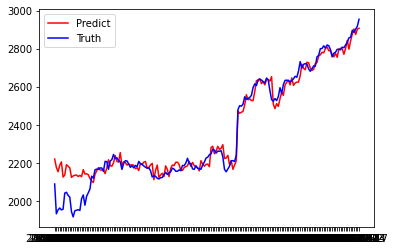

In [63]:
print("VALID")
plt.plot(valid_df['date'], model.predict(X_valid), label='Predict', color='red')
plt.plot(valid_df['date'], y_valid, label='Truth', color='blue')
plt.legend()
plt.show()

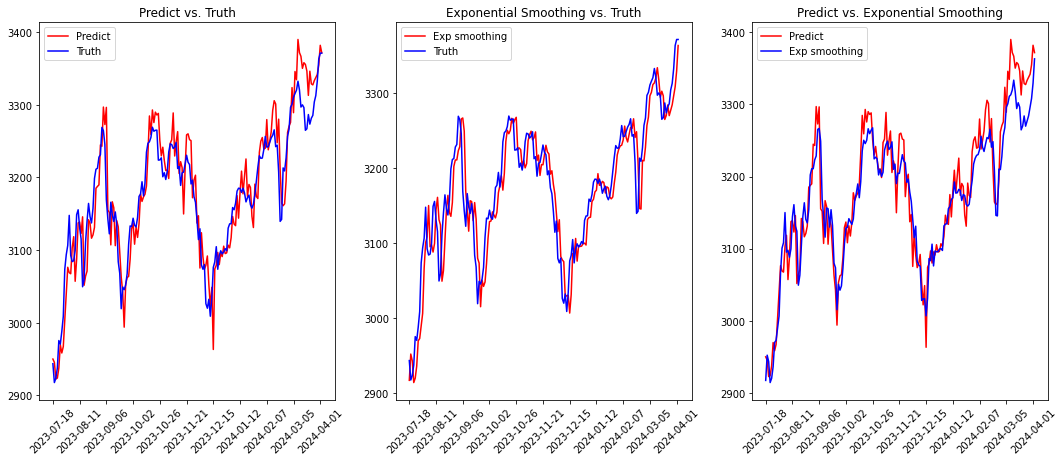

In [64]:
build_charts()

In [65]:
feature_importances = model.get_feature_importance(type='FeatureImportance')
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, feature_importances))
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
for feature, importance in sorted_importance_dict.items():
    print(f"{feature}: {importance}")

exponential_smoothing: 15.704025233120147
double_exponential_smoothing: 12.151999167661634
min: 11.493293552896244
average: 8.910669909481756
close: 7.592877502892455
double_exponential_smoothing_window7: 6.531527623380729
median: 6.315141450151949
max: 6.298528456872287
double_exponential_smoothing_window5: 2.8057817736517525
open: 2.275262281748796
median_window5: 2.154324906061802
median_window3: 1.5966091255166814
double_exponential_smoothing_window3: 1.0999356599812375
exponential_smoothing_window3: 0.9371751075960125
median_window2: 0.8955107529978957
max_window2: 0.8686971484609044
standard_deviation: 0.6229900106998096
embed_9: 0.5565338103461384
min_window7: 0.5513873037510317
average_window3: 0.4660825424779404
price_range_average: 0.4637784491848794
median_window7: 0.4245115951777689
embed_16: 0.3857337697890185
embed_20: 0.36788396973313203
price_range_average_window5: 0.3250744378085023
embed_24: 0.29679855608180683
price_range_average_window3: 0.2833061264885754
embed_33:

In [47]:
mlflow.start_run()

params = model.get_params()
for key, value in params.items():
    mlflow.log_param(key, value)
    
mlflow.log_metric("mape_train", mape(y_train, model.predict(X_train)))
mlflow.log_metric("mape_valid", mape(y_valid, model.predict(X_valid)))
mlflow.log_metric("mape_test", mape(y_test, model.predict(X_test)))

mlflow.catboost.log_model(model, "catboost_dataset_v3")

mlflow.end_run()

## Drop by importance

In [66]:
rubish = []
for feature, importance in sorted_importance_dict.items():
    if importance < 0.89:
        rubish.append(feature)
print(rubish)

['max_window2', 'standard_deviation', 'embed_9', 'min_window7', 'average_window3', 'price_range_average', 'median_window7', 'embed_16', 'embed_20', 'price_range_average_window5', 'embed_24', 'price_range_average_window3', 'embed_33', 'max_window5', 'standard_deviation_window5', 'standard_deviation_window7', 'embed_10', 'average_window2', 'embed_39', 'embed_5', 'embed_44', 'embed_15', 'embed_41', 'embed_22', 'embed_29', 'embed_35', 'price_range_average_window7', 'embed_25', 'embed_11', 'embed_28', 'embed_48', 'embed_42', 'embed_38', 'standard_deviation_window2', 'embed_46', 'embed_2', 'embed_7', 'embed_34', 'embed_18', 'embed_26', 'exponential_smoothing_window5', 'double_exponential_smoothing_window2', 'embed_49', 'max_window3', 'embed_43', 'embed_0', 'embed_40', 'embed_32', 'embed_21', 'embed_36', 'embed_37', 'embed_47', 'embed_27', 'embed_1', 'embed_17', 'embed_31', 'min_window3', 'embed_13', 'embed_8', 'price_range_average_window2', 'embed_6', 'embed_4', 'embed_23', 'embed_12', 'embe

In [67]:
train_df = train_df.drop(columns=rubish)
valid_df = valid_df.drop(columns=rubish)
test_df = test_df.drop(columns=rubish)
train_df.shape, valid_df.shape, test_df.shape

((847, 17), (182, 17), (182, 17))

In [68]:
X_train, y_train = train_df.drop(columns=['date', 'target']), train_df['target']
X_valid, y_valid = valid_df.drop(columns=['date', 'target']), valid_df['target']
X_test, y_test = test_df.drop(columns=['date', 'target']), test_df['target']

In [70]:
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train, verbose=False)

VALID


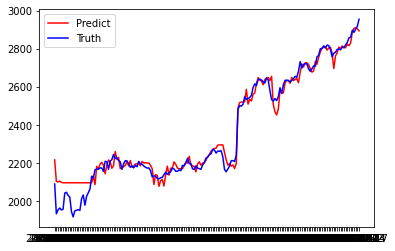

In [71]:
print("VALID")
plt.plot(valid_df['date'], model.predict(X_valid), label='Predict', color='red')
plt.plot(valid_df['date'], y_valid, label='Truth', color='blue')
plt.legend()
plt.show()

KeyError: 'exponential_smoothing_window7'

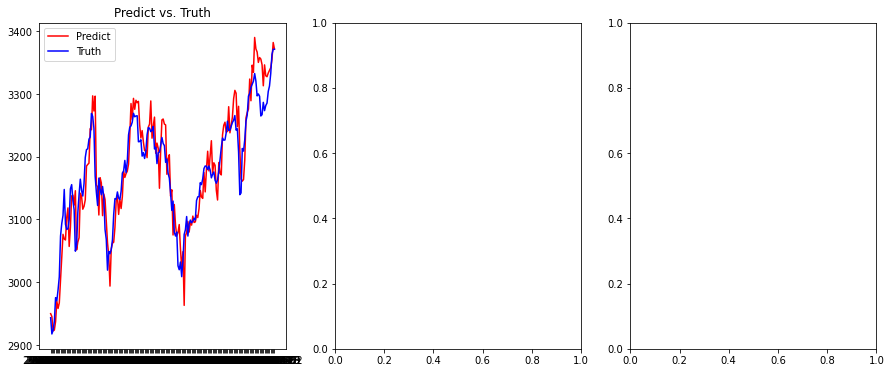

In [72]:
build_charts()

In [54]:
y_pred = model.predict(X_train)
print("------Train-----")
print("MAPE:", mape(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))

y_pred = model.predict(X_valid)
print("------Valid-----")
print("MAPE:", mape(y_valid, y_pred))
print("MAE:", mean_absolute_error(y_valid, y_pred))

y_pred = model.predict(X_test)
print("------Test-----")
print("MAPE:", mape(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

------Train-----
MAPE: 0.3561429612431574
MAE: 10.63451623212687
------Valid-----
MAPE: 1.7560319427176527
MAE: 37.79619635184353
------Test-----
MAPE: 0.8292086432459862
MAE: 26.226014360005966


In [73]:
mlflow.start_run()

params = model.get_params()
for key, value in params.items():
    mlflow.log_param(key, value)
    
mlflow.log_metric("mape_train", mape(y_train, model.predict(X_train)))
mlflow.log_metric("mape_valid", mape(y_valid, model.predict(X_valid)))
mlflow.log_metric("mape_test", mape(y_test, model.predict(X_test)))

mlflow.catboost.log_model(model, "catboost_dataset_v3_17_fea")

mlflow.end_run()